# **Todo Ventas S.A.**

## 1. Entendimiento de datos.

In [237]:
# imports base
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# utilidades varias
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# series temporales
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_white
import pymannkendall as mk

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics

from pylab import rcParams

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)

from xgboost import XGBRegressor
from sktime.forecasting.naive import NaiveForecaster

rcParams['figure.figsize'] = 15, 12

plt.style.use('seaborn-v0_8')

In [238]:
# Primer dataset contiene 5 columnas.
df = pd.read_csv("C:/Users/javir/OneDrive/Máster Data Science/Módulo 4 - Machine Learning/Series Temporales/Entregable/retail_todo_ventas.csv", low_memory=False)
df

InvoiceNo StockCode        Date         Country  TotalSales
0         536365     21730  2022-12-01  United Kingdom       25.50
1         536365     22752  2022-12-01  United Kingdom       15.30
2         536365     71053  2022-12-01  United Kingdom       20.34
3         536365    84029E  2022-12-01  United Kingdom       20.34
4         536365    84029G  2022-12-01  United Kingdom       20.34
...          ...       ...         ...             ...         ...
394325    581587     22730  2023-12-09          France       15.00
394326    581587     23254  2023-12-09          France       16.60
394327    581587     23255  2023-12-09          France       16.60
394328    581587     23256  2023-12-09          France       16.60
394329   A563185         B  2023-08-12  United Kingdom    11062.06

[394330 rows x 5 columns]

In [239]:
# Segundo dataset contiene dos columnas, la de Description no viene en el primer dataframe por lo que hay que unir los dos dataframes.
df2 = pd.read_csv("C:/Users/javir/OneDrive/Máster Data Science/Módulo 4 - Machine Learning/Series Temporales/Entregable/prod_dict.csv")
df2

StockCode                         Description
0            10002          INFLATABLE POLITICAL GLOBE
1            10080            GROOVY CACTUS INFLATABLE
2            10120                        DOGGY RUBBER
3            10125             MINI FUNKY DESIGN TAPES
4            10133        COLOURING PENCILS BROWN TUBE
...            ...                                 ...
3917  GIFT_0001_40  Dotcomgiftshop Gift Voucher £40.00
3918  GIFT_0001_50  Dotcomgiftshop Gift Voucher £50.00
3919             M                              Manual
3920          POST                             POSTAGE
3921             S                             SAMPLES

[3922 rows x 2 columns]

In [240]:
df2.StockCode.value_counts()

StockCode
23196    4
23236    4
22776    3
23396    3
23209    3
        ..
22375    1
22376    1
22377    1
22378    1
S        1
Name: count, Length: 3697, dtype: int64

In [241]:
# Dado que en el df2 hay varios códigos de stock con varias descripciones es necesario eliminar duplicados para que solo se cuente una venta.
df2 = df2.drop_duplicates(subset = 'StockCode', keep = 'first')
df2

StockCode                         Description
0            10002          INFLATABLE POLITICAL GLOBE
1            10080            GROOVY CACTUS INFLATABLE
2            10120                        DOGGY RUBBER
3            10125             MINI FUNKY DESIGN TAPES
4            10133        COLOURING PENCILS BROWN TUBE
...            ...                                 ...
3917  GIFT_0001_40  Dotcomgiftshop Gift Voucher £40.00
3918  GIFT_0001_50  Dotcomgiftshop Gift Voucher £50.00
3919             M                              Manual
3920          POST                             POSTAGE
3921             S                             SAMPLES

[3697 rows x 2 columns]

In [242]:
# Hacemos el merge con StockCode como valor fijado y how = left ya que me interesa quedarme con todas las filas del dataframe ya que aunque no tengan coincidencia en el StockCode me siguen interesando porque son ventas reales.
df = pd.merge(df, df2, how = 'left', on = 'StockCode')
df

InvoiceNo StockCode        Date         Country  TotalSales  \
0         536365     21730  2022-12-01  United Kingdom       25.50   
1         536365     22752  2022-12-01  United Kingdom       15.30   
2         536365     71053  2022-12-01  United Kingdom       20.34   
3         536365    84029E  2022-12-01  United Kingdom       20.34   
4         536365    84029G  2022-12-01  United Kingdom       20.34   
...          ...       ...         ...             ...         ...   
394325    581587     22730  2023-12-09          France       15.00   
394326    581587     23254  2023-12-09          France       16.60   
394327    581587     23255  2023-12-09          France       16.60   
394328    581587     23256  2023-12-09          France       16.60   
394329   A563185         B  2023-08-12  United Kingdom    11062.06   

                                Description  
0         GLASS STAR FROSTED T-LIGHT HOLDER  
1              SET 7 BABUSHKA NESTING BOXES  
2                       WHITE METAL LANTERN  
3            RED WOOLLY HOTTIE WHITE HEART.  
4       KNITTED UNION FLAG HOT WATER BOTTLE  
...                                     ...  
394325           ALARM CLOCK BAKELIKE IVORY  
394326         CHILDRENS CUTLERY DOLLY GIRL  
394327      CHILDRENS CUTLERY CIRCUS PARADE  
394328           CHILDRENS CUTLERY SPACEBOY  
394329                      Adjust bad debt  

[394330 rows x 6 columns]

In [243]:
# Paso a minúsculas los nombres de las columnas para facilitar el trabajo.
df.columns = [col.strip().lower() for col in df.columns]
df.columns

Index(['invoiceno', 'stockcode', 'date', 'country', 'totalsales',
       'description'],
      dtype='object')

In [244]:
print(df.shape) # El dataframe tiene 394330 filas y 6 columnas.
print(df.size) # Posee 2365980 valores. 

(394330, 6)
2365980


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394330 entries, 0 to 394329
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    394330 non-null  object 
 1   stockcode    394330 non-null  object 
 2   date         394330 non-null  object 
 3   country      394330 non-null  object 
 4   totalsales   394330 non-null  float64
 5   description  394330 non-null  object 
dtypes: float64(1), object(5)
memory usage: 18.1+ MB


In [246]:
# En el dataset aparece una columna que actúa como identificador, la variable invoiceno que es única para cada factura.
id_cols = ['invoiceno']
id_cols

['invoiceno']

In [247]:
# Lista para columnas numéricas.
numeric_cols = df.select_dtypes('float').columns.to_list()
numeric_cols

['totalsales']

In [248]:
# # Lista para columnas categóricas.
categoric_cols = df.select_dtypes('object').columns.to_list()
categoric_cols = [col for col in categoric_cols if col not in id_cols]
categoric_cols

['stockcode', 'date', 'country', 'description']

## 1.1 Análisis univariante de los datos

### 1.1.1 Variables numéricas

En primer lugar, veamos un resumen estadístico de las variables numéricas.

In [249]:
df.describe()

totalsales
count  394330.000000
mean       24.488495
std       103.726861
min         0.000000
25%         7.380000
50%        13.520000
75%        19.900000
max     38970.000000

Para hacer un análisis más profundo, podemos visualizar la distribución de la variable numérica mediante **histograma** y **boxplot**.

In [250]:
plt.rcParams['figure.figsize'] = [15, 5]

In [251]:
def plot_histogram_and_boxplot(df, column_name):
    # Borramos nulos para que desaparezcan de los gráficos. 
    df_ = df.loc[df[column_name].notnull()]
    
    fig = plt.figure()
    fig.suptitle(column_name, fontsize=16) 
    fig.subplots_adjust(wspace = 0.3) 
    # Creamos un histograma.
    ax1 = fig.add_subplot(121) 
    ax1.set_title("histogram") 
    # Ajustos bins a 70 para apreciar mejorar la distribución.
    ax1.hist(df_[column_name], bins = 25) 
    # Creamos un boxplot.
    ax2 = fig.add_subplot(122) 
    ax2.set_title("boxplot") 
    ax2.boxplot(df_[column_name], vert = False)

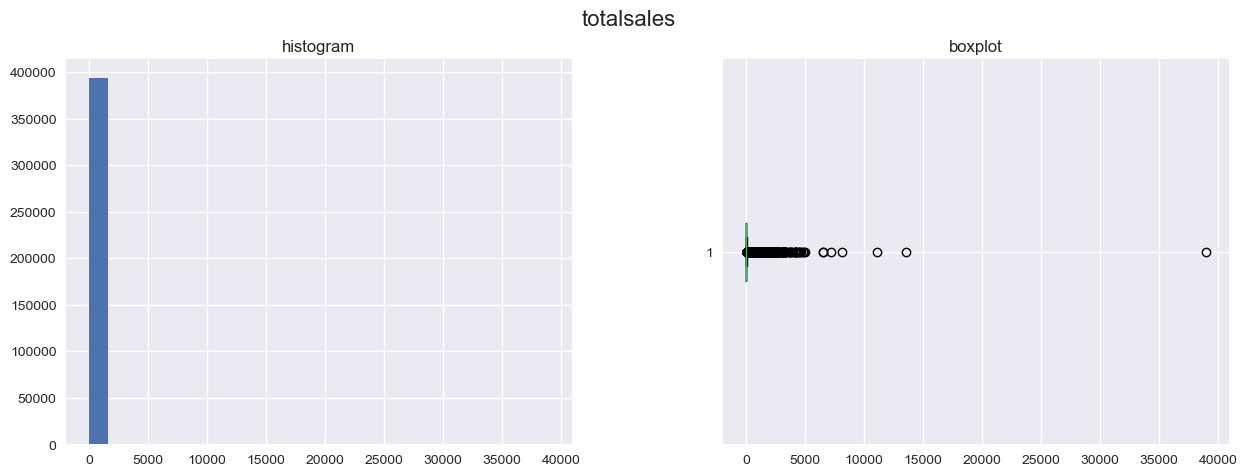

In [252]:
for c in numeric_cols:
    plot_histogram_and_boxplot(df = df, column_name = c)

Observamos que la gran mayoría de las ventas están en valores muy bajos (mediana de 13.52€) y que hay muy pocos outliers de gran importe, realmente son anecdóticos, sobre todo el de 38970€ que es el máximo de la variable. Otro dato que apunta que la mayor parte de las ventas son de importes muy bajos es que el percentil 75 es 19.90€, es decir, el 75% de las ventas es inferior a 20€.

### 1.1.2 Variables categóricas

Comenzamos analizando estadísticamente las variables categóricas.

In [253]:
df.describe(exclude='number')

invoiceno stockcode        date         country  \
count     394330    394330      394330          394330   
unique     19301      3697         305              10   
top       573585    85123A  2023-12-05  United Kingdom   
freq         833      2168        3898          367325   

                               description  
count                               394330  
unique                                3673  
top     WHITE HANGING HEART T-LIGHT HOLDER  
freq                                  2168

Visualizamos las variables categóricas en gráficos de barras para facilitar su interpretación.

In [254]:
def plot_barplot(df, column_name):
    fig = plt.figure()
    fig.suptitle(column_name, fontsize=16)
    df[column_name].value_counts().plot(kind = 'bar')

Debido al alto número de valores en cada variable el único gráfico que se puede analizar es el de la variable country, el resto de variables categóricas las voy a omitir dada su imposibilidad de interpretación.

In [255]:
categoric_cols_graphs = ['country']

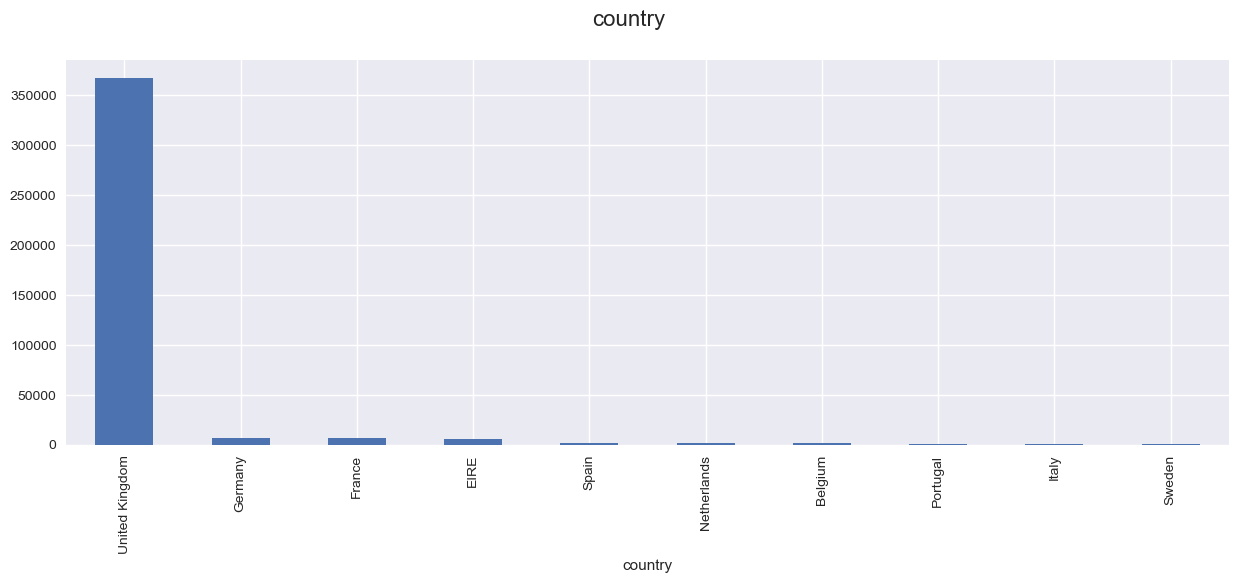

In [256]:
for c in categoric_cols_graphs:
    plot_barplot(df = df, column_name = c)

In [468]:
df.country.value_counts()

country
United Kingdom    367325
Germany             7040
France              6480
EIRE                6129
Spain               1894
Netherlands         1791
Belgium             1592
Portugal            1151
Italy                579
Sweden               349
Name: count, dtype: int64

United Kingdom es el país en el que más ventas se realizan con mucha diferencia, más de 367000 ventas que representa el 93% de las mismas.

# 2. Preparación de datos

## 2.1 Ajuste de tipos

In [258]:
# Pasamos a formato datetime la columna date ya que contiene una fecha.
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394330 entries, 0 to 394329
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    394330 non-null  object        
 1   stockcode    394330 non-null  object        
 2   date         394330 non-null  datetime64[ns]
 3   country      394330 non-null  object        
 4   totalsales   394330 non-null  float64       
 5   description  394330 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 18.1+ MB


## 2.2 Eliminación de duplicados

In [259]:
df.duplicated().sum()

2

In [260]:
# Al haber solo dos duplicados y ante la posibilidad de que no sean duplicados sino que sean dos mismos prodcutos en una misma factura decido no eliminarlos.
df.loc[df.duplicated()]

invoiceno stockcode       date         country  totalsales  \
145882    554084     23298 2023-05-22  United Kingdom       14.85   
329559    575335     23203 2023-11-09  United Kingdom      537.00   

                      description  
145882             SPOTTY BUNTING  
329559  JUMBO BAG DOILEY PATTERNS

## 2.3 Tratamiento de nulos

In [261]:
# Observamos que no hay valores nulos en el dataframe.
df.isna().sum()

invoiceno      0
stockcode      0
date           0
country        0
totalsales     0
description    0
dtype: int64

# 3. Análisis por países
### **Ventas de United Kingdom**

In [262]:
df['totalsales'].groupby(df['country']).sum()

country
Belgium             36806.580
EIRE               261750.070
France             192274.730
Germany            210139.590
Italy               14989.270
Netherlands        261986.880
Portugal            30933.430
Spain               55980.350
Sweden              36024.690
United Kingdom    8555662.571
Name: totalsales, dtype: float64

Filtrando cada país por su total de ventas se oberva que United Kingdom es con diferencia el país que más ventas produce. Por este motivo voy a comenzar con el análisis de las ventas de este país.

In [263]:
df_uk = df.query("country=='United Kingdom'")
df_uk = df_uk.sort_values(by='date')
df_uk

invoiceno stockcode       date         country  totalsales  \
0         536365     21730 2022-12-01  United Kingdom       25.50   
1502      536566     22771 2022-12-01  United Kingdom       12.50   
1501      536566     21668 2022-12-01  United Kingdom        7.50   
1500      536565     21369 2022-12-01  United Kingdom        3.75   
1499      536564     37449 2022-12-01  United Kingdom       39.80   
...          ...       ...        ...             ...         ...   
393524    581492     22960 2023-12-09  United Kingdom       16.58   
393525    581492     22961 2023-12-09  United Kingdom       29.61   
393526    581492     22962 2023-12-09  United Kingdom        4.89   
393512    581492     22900 2023-12-09  United Kingdom       19.89   
393260    581489     22061 2023-12-09  United Kingdom      141.60   

                                description  
0         GLASS STAR FROSTED T-LIGHT HOLDER  
1502    CLEAR DRAWER KNOB ACRYLIC EDWARDIAN  
1501         RED STRIPE CERAMIC DRAWER KNOB  
1500             MIRRORED WALL ART SPLODGES  
1499     CERAMIC CAKE STAND + HANGING CAKES  
...                                     ...  
393524             JAM MAKING SET WITH JARS  
393525               JAM MAKING SET PRINTED  
393526                JAM JAR WITH PINK LID  
393512       SET 2 TEA TOWELS I LOVE LONDON  
393260  LARGE CAKE STAND  HANGING STRAWBERY  

[367325 rows x 6 columns]

In [264]:
df_uk = df_uk[['date', 'totalsales']]
df_uk

date  totalsales
0      2022-12-01       25.50
1502   2022-12-01       12.50
1501   2022-12-01        7.50
1500   2022-12-01        3.75
1499   2022-12-01       39.80
...           ...         ...
393524 2023-12-09       16.58
393525 2023-12-09       29.61
393526 2023-12-09        4.89
393512 2023-12-09       19.89
393260 2023-12-09      141.60

[367325 rows x 2 columns]

In [265]:
df_uk.columns = ['ds', 'y']
df_uk

ds       y
0      2022-12-01   25.50
1502   2022-12-01   12.50
1501   2022-12-01    7.50
1500   2022-12-01    3.75
1499   2022-12-01   39.80
...           ...     ...
393524 2023-12-09   16.58
393525 2023-12-09   29.61
393526 2023-12-09    4.89
393512 2023-12-09   19.89
393260 2023-12-09  141.60

[367325 rows x 2 columns]

In [266]:
# Agrupamos las ventas por días y vemos que hay algunos días que no aparecen en el df, por ejemplo el 2022-12-04.
df_uk = df_uk.groupby('ds', as_index=False)['y'].sum()
df_uk

ds         y
0   2022-12-01  53520.58
1   2022-12-02  46422.64
2   2022-12-03  40483.46
3   2022-12-05  25018.63
4   2022-12-06  51731.61
..         ...       ...
300 2023-12-05  83274.82
301 2023-12-06  51767.13
302 2023-12-07  54270.50
303 2023-12-08  77242.10
304 2023-12-09  26956.27

[305 rows x 2 columns]

In [ ]:
df_uk.groupby('ds', as_index=False)['y'].sum()


In [267]:
# Para solucionar la falta de días en el periodo creamos un data range desde la primera fecha a la última de la serie de UK para tener todos los días en la serie.
date_range = pd.date_range(start='2022-12-01', end='2023-12-09', freq='D')
date_range

DatetimeIndex(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10',
               ...
               '2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-09'],
              dtype='datetime64[ns]', length=374, freq='D')

In [268]:
df_uk = df_uk.set_index('ds')

df_uk = df_uk.reindex(date_range)
df_uk

y
2022-12-01  53520.58
2022-12-02  46422.64
2022-12-03  40483.46
2022-12-04       NaN
2022-12-05  25018.63
...              ...
2023-12-05  83274.82
2023-12-06  51767.13
2023-12-07  54270.50
2023-12-08  77242.10
2023-12-09  26956.27

[374 rows x 1 columns]

In [269]:
# Decido utilizar para imputar los nulos que hay en las nuevas fechas una media móvil para que el valor que se impute esté influenciado por los valores de antes y de después y así utilicemos un valor más aproximado. También he probado con forward fill y backward fill y dan métricas peores.
# Con la interpolación lineal prácticamente es el mismo resultado pero al haber comprobado posteriormente que hay estacionalidad semanal la media móvil capta mejor este componente a parte de que no se ve relación lineal en la serie.
df_uk['y'] = df_uk['y'].fillna(df_uk['y'].rolling(window=12, min_periods=1).mean())

In [270]:
df_uk = df_uk.reset_index()
df_uk.columns = ['ds', 'y']
df_uk

ds             y
0   2022-12-01  53520.580000
1   2022-12-02  46422.640000
2   2022-12-03  40483.460000
3   2022-12-04  46808.893333
4   2022-12-05  25018.630000
..         ...           ...
369 2023-12-05  83274.820000
370 2023-12-06  51767.130000
371 2023-12-07  54270.500000
372 2023-12-08  77242.100000
373 2023-12-09  26956.270000

[374 rows x 2 columns]

In [271]:
px.line(df_uk, x = 'ds', y = 'y')

En la serie temporal se observa que tiene cierto componente estable de subidas y bajadas durante gran parte del año excepto entre los meses de septiembre y enero que tiene tendencia ascendente y alcanza sus máximos picos.

## 3.1 Análisis descriptivo

In [272]:
df_uk.describe()

ds              y
count                            374     374.000000
mean   2023-06-05 12:00:00.000000256   27804.888998
min              2022-12-01 00:00:00    3325.140000
25%              2023-03-04 06:00:00   18141.637750
50%              2023-06-05 12:00:00   24401.300500
75%              2023-09-06 18:00:00   33600.118000
max              2023-12-09 00:00:00  107229.100000
std                              NaN   15461.613782

### 3.1.1 Modelo aditivo

In [273]:
# Asumimos estacionalidad semanal que ya confirmaremos más adelante.
result = seasonal_decompose(df_uk['y'], model = 'additive', period = 7)
result

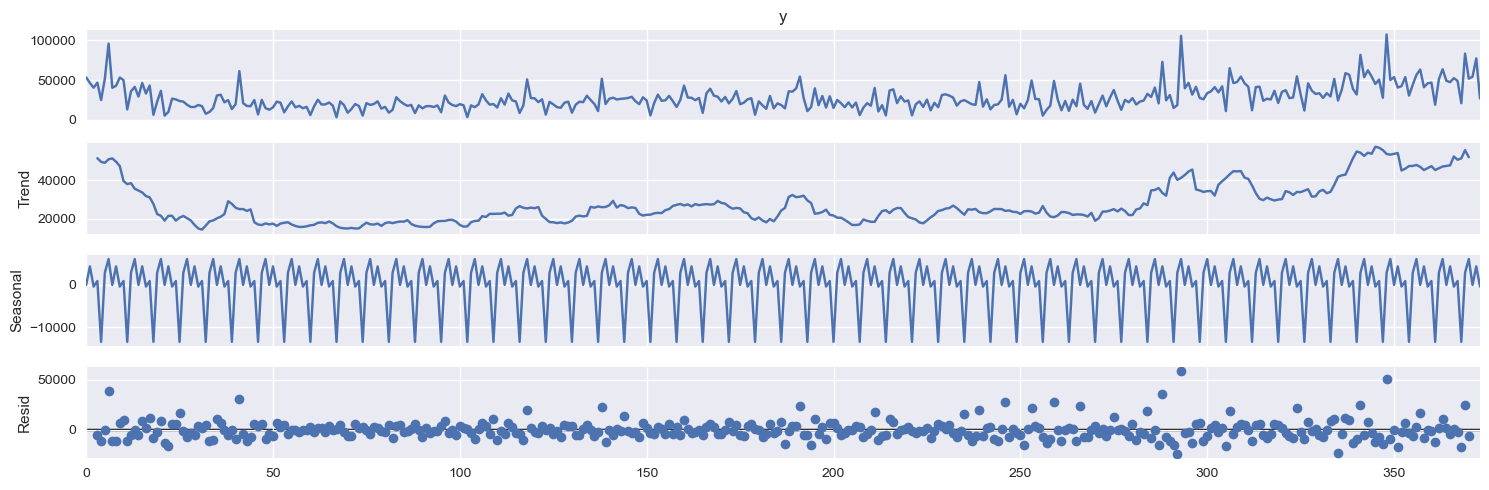

In [274]:
result.plot()
plt.show()

Observamos tendencia ascendente a partir del mes de septiembre y empiez a bajar para luego estabilizarse a partir de enero. En cuanto a la estacionalidad se confirma la estacionalidad semanal. Si miramos los residuos vemos que hacia el final de la serie se observa que le cuesta más al modelo captar los valores correctos.

In [275]:
df_ad = df_uk.copy()
df_ad['observed'] = result.observed
df_ad['trend'] = result.trend
df_ad['seasonal'] = result.seasonal
df_ad['residual'] = result.resid
df_ad

ds             y      observed         trend      seasonal  \
0   2022-12-01  53520.580000  53520.580000           NaN    -71.312037   
1   2022-12-02  46422.640000  46422.640000           NaN   4299.412413   
2   2022-12-03  40483.460000  40483.460000           NaN   -453.184698   
3   2022-12-04  46808.893333  46808.893333  51397.143333    857.297108   
4   2022-12-05  25018.630000  25018.630000  49524.081905 -13480.257586   
..         ...           ...           ...           ...           ...   
369 2023-12-05  83274.820000  83274.820000  55577.775286   2808.837450   
370 2023-12-06  51767.130000  51767.130000  51934.725286   6039.207349   
371 2023-12-07  54270.500000  54270.500000           NaN    -71.312037   
372 2023-12-08  77242.100000  77242.100000           NaN   4299.412413   
373 2023-12-09  26956.270000  26956.270000           NaN   -453.184698   

         residual  
0             NaN  
1             NaN  
2             NaN  
3    -5445.547108  
4   -11025.194319  
..            ...  
369  24888.207264  
370  -6206.802635  
371           NaN  
372           NaN  
373           NaN  

[374 rows x 6 columns]

In [276]:
df_ad['estimated'] = df_ad['trend'] + df_ad['seasonal']
df_uk_matrix = df_ad[['y', 'estimated']].copy()
df_uk_matrix = df_uk_matrix[df_uk_matrix['estimated'].isna() == False]
df_uk_matrix

y     estimated
3    46808.893333  52254.440442
4    25018.630000  36043.824319
5    51731.610000  51835.275069
6    95794.190000  56886.507825
7    40409.150000  51224.700344
..            ...           ...
366  52457.620000  51833.214873
367  48992.997000  51453.270966
368  21039.260000  37842.396272
369  83274.820000  58386.612736
370  51767.130000  57973.932635

[368 rows x 2 columns]

In [277]:
px.line(df_uk_matrix)

La estimación se acerca algo a los resultados reales pero tiene problemas para captar los picos superiores y los últimos meses de la serie sobre todo.
A continuación, calculamos las métricas.

In [278]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt

In [279]:
print('El error absoluto medio (MAE) es:', mean_absolute_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error medio cuadrado (MSE) es:', mean_squared_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error cuadrático medio (RMSE) es:', sqrt(mean_squared_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y'])))

El error absoluto medio (MAE) es: 6347.522536891735
El error medio cuadrado (MSE) es: 87496369.04768091
El error cuadrático medio (RMSE) es: 9353.949382356146


In [280]:
print('El r cuadrado (R2) es:', r2_score(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error porcentual absoluto medio (MAPE) es:', mean_absolute_percentage_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))

El r cuadrado (R2) es: 0.6203377015490394
El error porcentual absoluto medio (MAPE) es: 0.270847701803717


Son un poco altas las métricas ya que tiene problemas el estimador para captar la volatilidad de la serie. Vamos a probar con el modelo multiplicativo para comprobar si se acerca más a la realidad.

### 3.1.2 Modelo Multiplicativo

In [281]:
result = seasonal_decompose(df_uk['y'], model = 'multiplicative', period = 7)
result

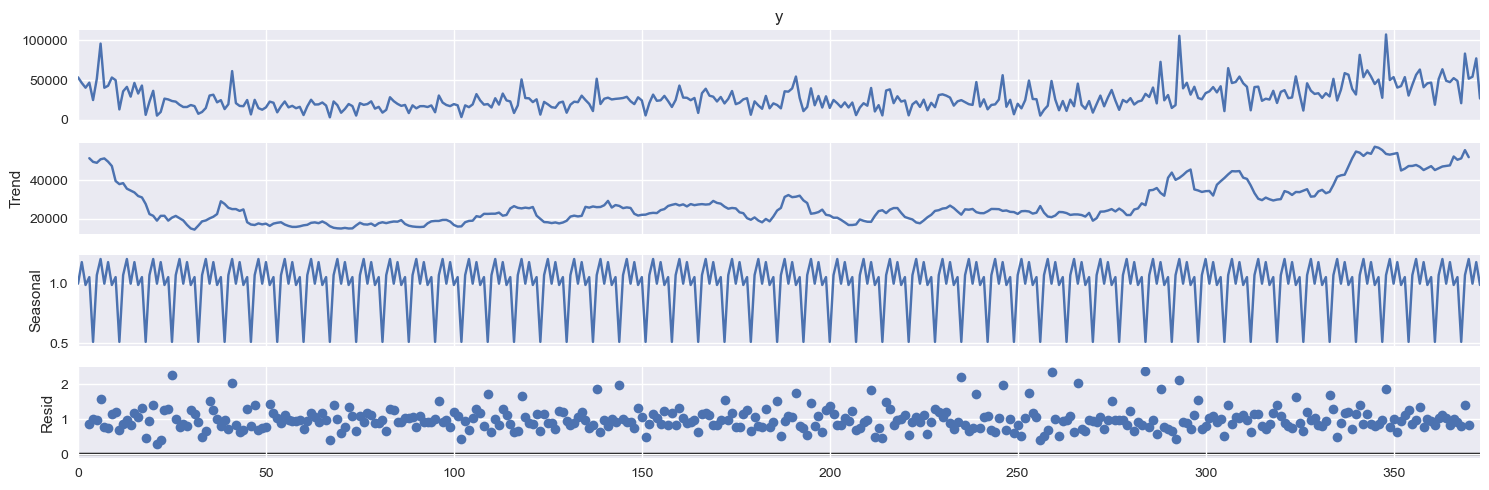

In [282]:
result.plot()
plt.show()

Con el modelo multiplicativo tanto la estacionalidad como la tendencia tienen el mismo comportamiento y los residuos tienen mayor error en los picos superiores de ventas.

In [283]:
df_mul = df_uk.copy()
df_mul['observed'] = result.observed
df_mul['trend'] = result.trend
df_mul['seasonal'] = result.seasonal
df_mul['residual'] = result.resid
df_mul

ds             y      observed         trend  seasonal  residual
0   2022-12-01  53520.580000  53520.580000           NaN  0.997716       NaN
1   2022-12-02  46422.640000  46422.640000           NaN  1.178639       NaN
2   2022-12-03  40483.460000  40483.460000           NaN  0.986736       NaN
3   2022-12-04  46808.893333  46808.893333  51397.143333  1.052783  0.865068
4   2022-12-05  25018.630000  25018.630000  49524.081905  0.509731  0.991073
..         ...           ...           ...           ...       ...       ...
369 2023-12-05  83274.820000  83274.820000  55577.775286  1.069671  1.400755
370 2023-12-06  51767.130000  51767.130000  51934.725286  1.204723  0.827388
371 2023-12-07  54270.500000  54270.500000           NaN  0.997716       NaN
372 2023-12-08  77242.100000  77242.100000           NaN  1.178639       NaN
373 2023-12-09  26956.270000  26956.270000           NaN  0.986736       NaN

[374 rows x 6 columns]

In [284]:
df_mul['estimated'] = df_mul['trend'] + df_mul['seasonal']
df_uk_matrix = df_mul[['y', 'estimated']].copy()
df_uk_matrix = df_uk_matrix[df_uk_matrix['estimated'].isna() == False]
df_uk_matrix

y     estimated
3    46808.893333  51398.196117
4    25018.630000  49524.591636
5    51731.610000  49027.507290
6    95794.190000  50848.505199
7    40409.150000  51297.010097
..            ...           ...
366  52457.620000  52287.386308
367  48992.997000  50597.026640
368  21039.260000  51323.163589
369  83274.820000  55578.844957
370  51767.130000  51935.930009

[368 rows x 2 columns]

In [285]:
px.line(df_uk_matrix)

Con el modelo multiplicativo el modelo tiene más dificultades para captar el nivel de ventas, sobre todo con los niveles bajos que el aditivo los cogía mejor.

In [286]:
print('El error abosulo medio (MAE) es:', mean_absolute_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error medio cuadrado (MSE) es:', mean_squared_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error cuadrático medio (RMSE) es:', sqrt(mean_squared_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y'])))

El error abosulo medio (MAE) es: 7392.715183961806
El error medio cuadrado (MSE) es: 122801721.83025904
El error cuadrático medio (RMSE) es: 11081.593830774482


In [287]:
print('El r cuadrado (R2) es:', r2_score(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))
print('El error porcentual absoluto medio (MAPE) es:', mean_absolute_percentage_error(y_pred = df_uk_matrix['estimated'], y_true = df_uk_matrix['y']))

El r cuadrado (R2) es: 0.46714150002722443
El error porcentual absoluto medio (MAPE) es: 0.38587763452393803


Analizando las métricas también se aprecia empeoramiento en los valores, por ejemplo el R^2 baja 16 puntos por lo tanto el modelo explica peor la variabilidad de las ventas. El MAPE también un 10% por lo que habría un 10% más de errores. Por lo tanto, nos quedamos con el modelo aditivo ya que presenta mejores métricas. Esto quiere decir que las variaciones alrededor de la tendencia no varían con el nivel de la serie temporal.

### 3.1.3 Autocorrelación y autocorrelación parcial

In [288]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

In [289]:
# Cálculo de la autocorrelación con lag=1.
df_pax_corr = df_uk['y'].autocorr()
df_pax_corr

0.3828320569603558

In [290]:
# Calculo de la autocorrelación hasta un lag máximo.
autocorr_values = acf(df_uk['y'], nlags=36)
autocorr_values

array([1.        , 0.38140383, 0.38040643, 0.38965707, 0.36544651,
       0.38855662, 0.34734151, 0.52433055, 0.26863372, 0.33503062,
       0.28828814, 0.27354853, 0.23929446, 0.27915286, 0.42004307,
       0.23269209, 0.2696712 , 0.19365807, 0.23578142, 0.20362541,
       0.2276763 , 0.3686976 , 0.19379209, 0.20600465, 0.21572964,
       0.17078774, 0.1689368 , 0.18000572, 0.3108395 , 0.17705795,
       0.1710443 , 0.1845003 , 0.1361635 , 0.11338828, 0.17705984,
       0.31934967, 0.11314871])

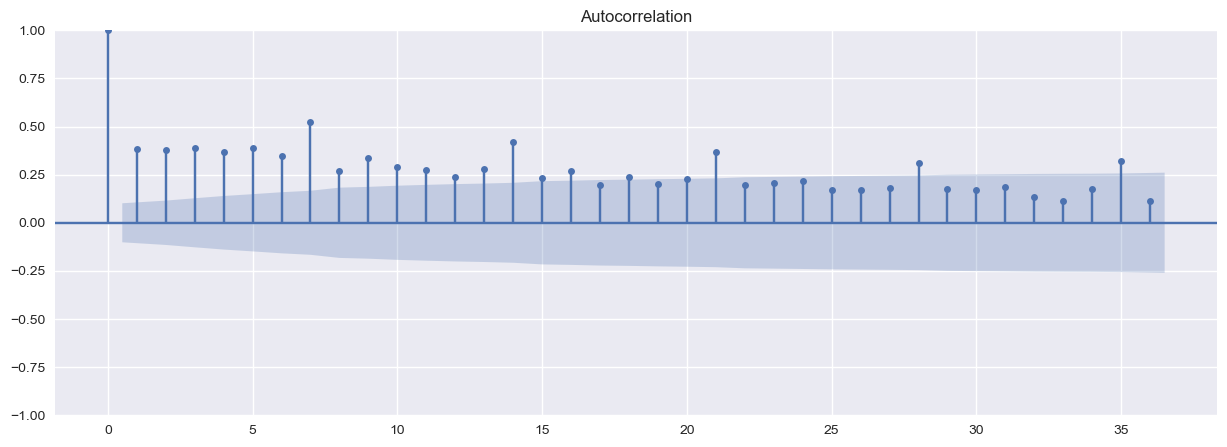

In [291]:
plot_acf(df_uk['y'], lags = 36)
plt.show()

El análisis de correlación refleja una tendencia general (correlación alta en lags pequeños y decreciente). Posee un patrón semanal claro, con valores significativamente correlacionados cada 7 días, es decir, la serie explica mejor los valores de hace una semana que los del día anterior.

In [292]:
# Calcular la autocorrelación parcial hasta un lag máximo.
pautocorr_values = pacf(df_uk['y'], nlags=36)
pautocorr_values

array([ 1.00000000e+00,  3.82426357e-01,  2.76663754e-01,  2.29844227e-01,
        1.55772629e-01,  1.68681235e-01,  8.67049316e-02,  3.40889112e-01,
       -1.09106561e-01,  4.69176344e-02, -5.75726579e-02, -1.36662481e-02,
       -1.01887997e-01,  6.65195467e-02,  1.83728253e-01,  1.35424298e-02,
       -7.26742138e-04, -7.43259684e-02,  2.14231070e-02, -2.76941225e-02,
        2.07876782e-03,  1.60203766e-01, -3.55365833e-03, -4.89909742e-02,
        5.77943749e-02, -7.71389216e-02, -2.07350398e-03, -4.73486665e-02,
        1.13033643e-01,  5.82310098e-03, -1.51123599e-02,  1.83666815e-02,
       -2.21627246e-02, -7.16094228e-02,  3.77828606e-02,  1.65523332e-01,
       -8.09212164e-02])

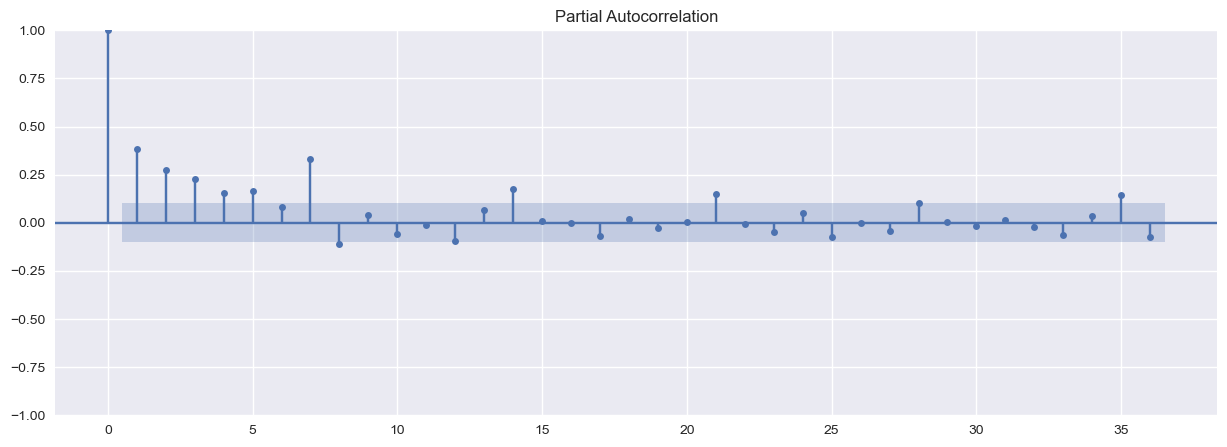

In [293]:
# La autocorrelación parcial muestra el efecto de un instante concreto (mes concreto) eliminando los efectos de los instantes intermedios.
plot_pacf(df_uk['y'], lags = 36)
plt.show()

También se observa en la autocorrelación parcial la estacionalidad semanal.

### 3.1.4 Procesos estacionarios

In [294]:
result = adfuller(df_uk['y'])
print('p-value of the Dickey-Fuller test: %f' % result[1])

p-value of the Dickey-Fuller test: 0.590735


In [295]:
px.line(df_uk, x = 'ds', y = 'y')

El test de Dickey-Fuller da un p-value de 0.5907 por lo que es superior a 0.05 que se conidera el límite por lo alto de la estacionariedad. Por lo tanto la serie temporal de las ventas en United Kingdom no es estacionaria.

## 3.2 Desarrollo de métodos, análisis de resultados y selección de modelo

### 3.2.1 Prophet

Vamos a utilizar la herramienta Prophet para la predicción de la serie temporal.

In [296]:
m = Prophet()
m.fit(df_uk)

17:05:37 - cmdstanpy - INFO - Chain [1] start processing
17:05:37 - cmdstanpy - INFO - Chain [1] done processing


In [297]:
# Proyectamos a un mes vista que es nuestro objetivo de predicción de ventas.

future_df = m.make_future_dataframe(periods=30, freq='D') 
future_df

ds
0   2022-12-01
1   2022-12-02
2   2022-12-03
3   2022-12-04
4   2022-12-05
..         ...
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

[404 rows x 1 columns]

In [298]:
forecast_df = m.predict(future_df)

display(forecast_df.head(5))
display(forecast_df.tail(5))

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2022-12-01  27628.971593  14215.036728  43104.930827  27628.971593   
1 2022-12-02  27545.021557  18803.679449  47036.480349  27545.021557   
2 2022-12-03  27461.071521  12658.563262  42221.128090  27461.071521   
3 2022-12-04  27377.121485  13655.070371  41851.555758  27377.121485   
4 2022-12-05  27293.171449    -81.425346  27465.100362  27293.171449   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  27628.971593      258.304179            258.304179            258.304179   
1  27545.021557     4703.912863           4703.912863           4703.912863   
2  27461.071521     -904.098305           -904.098305           -904.098305   
3  27377.121485      841.428828            841.428828            841.428828   
4  27293.171449   -13544.720837         -13544.720837         -13544.720837   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0    258.304179    258.304179    258.304179                   0.0   
1   4703.912863   4703.912863   4703.912863                   0.0   
2   -904.098305   -904.098305   -904.098305                   0.0   
3    841.428828    841.428828    841.428828                   0.0   
4 -13544.720837 -13544.720837 -13544.720837                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  27887.275772  
1                         0.0                         0.0  32248.934420  
2                         0.0                         0.0  26556.973216  
3                         0.0                         0.0  28218.550313  
4                         0.0                         0.0  13748.450612

ds         trend    yhat_lower    yhat_upper   trend_lower  \
399 2024-01-04  54399.454560  40867.147463  69123.964993  54051.814330   
400 2024-01-05  54598.391511  44226.178679  73781.276151  54229.422224   
401 2024-01-06  54797.328461  38669.392289  68590.476973  54413.742001   
402 2024-01-07  54996.265412  42570.805801  70777.625526  54586.055946   
403 2024-01-08  55195.202363  27563.012403  55590.514002  54764.193922   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
399  54770.892590      258.304179            258.304179            258.304179   
400  55004.159558     4703.912863           4703.912863           4703.912863   
401  55222.705726     -904.098305           -904.098305           -904.098305   
402  55446.576982      841.428828            841.428828            841.428828   
403  55675.608091   -13544.720837         -13544.720837         -13544.720837   

           weekly  weekly_lower  weekly_upper  multiplicative_terms  \
399    258.304179    258.304179    258.304179                   0.0   
400   4703.912863   4703.912863   4703.912863                   0.0   
401   -904.098305   -904.098305   -904.098305                   0.0   
402    841.428828    841.428828    841.428828                   0.0   
403 -13544.720837 -13544.720837 -13544.720837                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
399                         0.0                         0.0  54657.758739  
400                         0.0                         0.0  59302.304373  
401                         0.0                         0.0  53893.230157  
402                         0.0                         0.0  55837.694240  
403                         0.0                         0.0  41650.481526

In [299]:
forecast_clean = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_clean

ds          yhat    yhat_lower    yhat_upper
0   2022-12-01  27887.275772  14215.036728  43104.930827
1   2022-12-02  32248.934420  18803.679449  47036.480349
2   2022-12-03  26556.973216  12658.563262  42221.128090
3   2022-12-04  28218.550313  13655.070371  41851.555758
4   2022-12-05  13748.450612    -81.425346  27465.100362
..         ...           ...           ...           ...
399 2024-01-04  54657.758739  40867.147463  69123.964993
400 2024-01-05  59302.304373  44226.178679  73781.276151
401 2024-01-06  53893.230157  38669.392289  68590.476973
402 2024-01-07  55837.694240  42570.805801  70777.625526
403 2024-01-08  41650.481526  27563.012403  55590.514002

[404 rows x 4 columns]

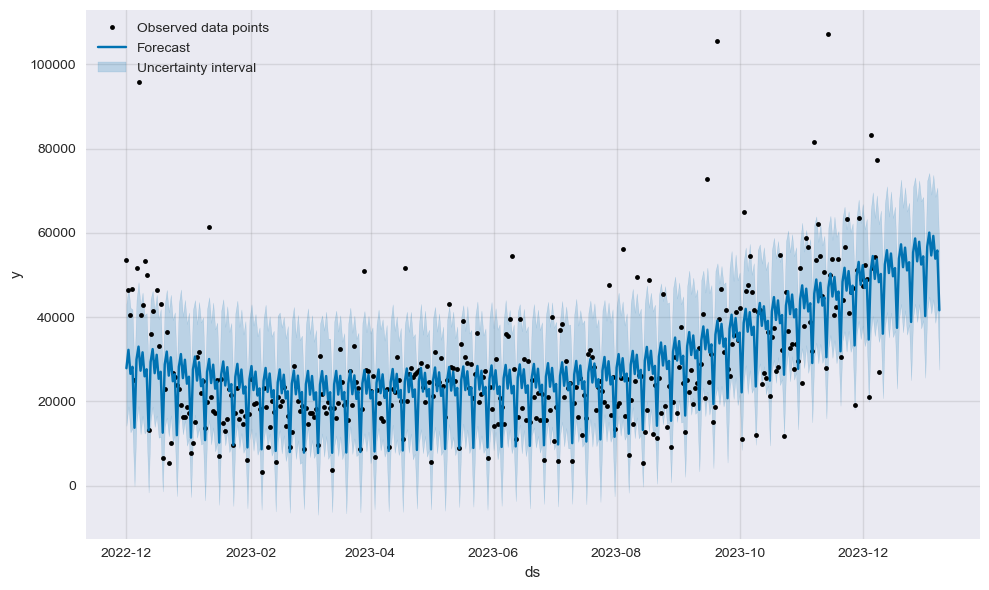

In [300]:
plot_forecast = plot(m, forecast_df, include_legend=True)

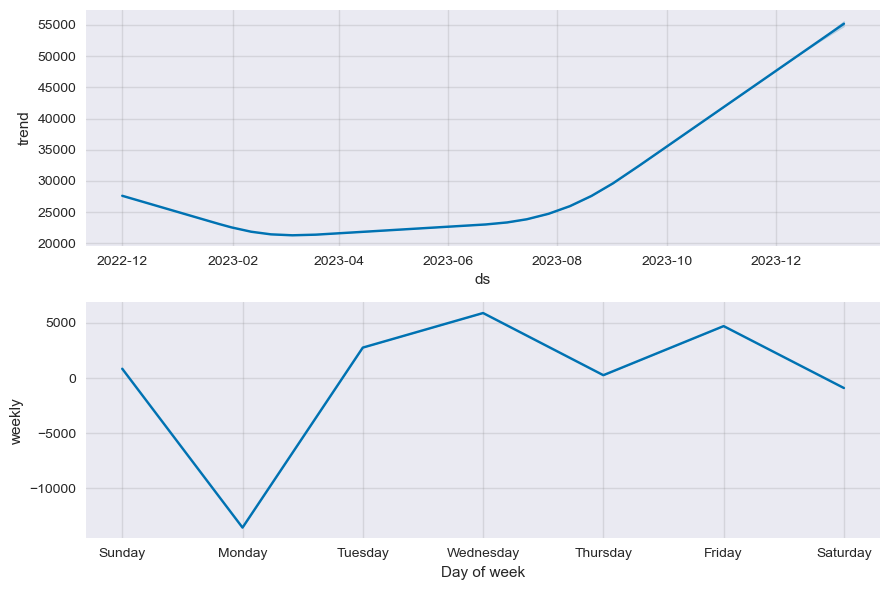

In [301]:
decompose_ = plot_components(m, forecast_df)

La tendencia es ascendente después del verano y la estacionalidad es más marcada en durante los miércoles y viernes, tiene un pico inferior los lunes.

### **Evaluación de las predicciones**

In [302]:
# Realizo partición train y test asiganndo un 80% de los días a train (hasta el 2023-10-01) y 20% a test.
train_df = df_uk.loc[df_uk['ds'] < '2023-10-01']
test_df = df_uk.loc[df_uk['ds'] >= '2023-10-01']

In [303]:
model_ml = Prophet(weekly_seasonality=True)
model_ml.fit(train_df)

17:05:38 - cmdstanpy - INFO - Chain [1] start processing
17:05:38 - cmdstanpy - INFO - Chain [1] done processing


In [304]:
future_ml_df = model_ml.make_future_dataframe(periods =len(test_df)+30, freq = 'D')
future_ml_df

ds
0   2022-12-01
1   2022-12-02
2   2022-12-03
3   2022-12-04
4   2022-12-05
..         ...
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

[404 rows x 1 columns]

In [305]:
forecast_ml_df = model_ml.predict(future_ml_df)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_ml_df

ds          yhat    yhat_lower    yhat_upper
0   2022-12-01  32048.929483  18857.701611  46281.582774
1   2022-12-02  37178.154420  24058.773811  49475.117919
2   2022-12-03  31075.577578  17541.843764  44601.092746
3   2022-12-04  32603.878534  19227.646378  46458.309155
4   2022-12-05  19591.200996   5541.505948  32636.256073
..         ...           ...           ...           ...
399 2024-01-04  32923.653274  20534.544265  46922.263683
400 2024-01-05  38279.977632  24252.786306  52062.060947
401 2024-01-06  32404.500209  19105.041926  45728.934098
402 2024-01-07  34159.900586  20523.503577  47773.752141
403 2024-01-08  21374.322468   8049.434580  34202.828944

[404 rows x 4 columns]

In [306]:
px.line(pd.concat([df_uk.set_index('ds')['y'], forecast_ml_df.set_index('ds')['yhat']], axis = 1), title = 'Proyecciones con Prophet | Estacionalidad aditiva')

La predicción funciona mejor con los datos de train pero al llegar a las fechas de test tiene más problemas para captar los picos que alcanzan. En cuanto a la tendencia si capta algo su aumento. A continuación, vamos a probar con un modelo multiplicativo buscando una mejor predicción.

In [307]:
m_pax_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True)
m_pax_mul.fit(train_df)

17:05:39 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
future_pax_mul = m_pax_mul.make_future_dataframe(periods = len(test_df)+30, freq = 'D')
display(future_pax_mul.head(10))
display(future_pax_mul.tail(10))

ds
0 2022-12-01
1 2022-12-02
2 2022-12-03
3 2022-12-04
4 2022-12-05
5 2022-12-06
6 2022-12-07
7 2022-12-08
8 2022-12-09
9 2022-12-10

ds
394 2023-12-30
395 2023-12-31
396 2024-01-01
397 2024-01-02
398 2024-01-03
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

In [309]:
forecast_pax_mul = m_pax_mul.predict(future_pax_mul)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
px.line(pd.concat([df_uk.set_index('ds')['y'], forecast_pax_mul.set_index('ds')['yhat']], axis = 1), title = 'Proyecciones con Prophet - Estacionalidad multiplicativa')

En este caso la predicción también funciona mejor con los datos de train pero al llegar a las fechas de test tiene más problemas para captar los picos que alcanzan al igual que la aditiva. El aumento de la tendencia también es captado. En cuanto al último mes de predicción el modelo multiplicativo indica que las ventas se mantendrían estables con una ligera tendencia ascendente.

### **Evaluación cruzada**

Mediante la función de evaluación cruzada vamos a realizar la evaluación del modelo.

In [310]:
# Establecemos un periodo inicial de 120 días, aumentando el intervalo en 7 días y horizonte de 4 semanas al haber estacionalidad semanal.
cv_add = cross_validation(model = model_ml, initial='120 days', period='7 days', horizon = '28 days')

  0%|          | 0/23 [00:00<?, ?it/s]

17:05:39 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing
17:05:39 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing
17:05:39 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing
17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1]

In [311]:
cv_mul = cross_validation(model = m_pax_mul,  initial='120 days', period='7 days', horizon = '28 days')

  0%|          | 0/23 [00:00<?, ?it/s]

17:05:43 - cmdstanpy - INFO - Chain [1] start processing
17:05:43 - cmdstanpy - INFO - Chain [1] done processing
17:05:43 - cmdstanpy - INFO - Chain [1] start processing
17:05:43 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
17:05:44 - cmdstanpy - INFO - Chain [1] start processing
17:05:45 - cmdstanpy - INFO - Chain [1] done processing
17:05:45 - cmdstanpy - INFO - Chain [1] start processing
17:05:45 - cmdstanpy - INFO - Chain [1]

In [312]:
df_performance_add = performance_metrics(cv_add)
display(df_performance_add)

horizon           mse          rmse          mae      mape     mdape  \
0   3 days  5.005578e+07   7075.010879  4991.312292  0.349159  0.207543   
1   4 days  7.812808e+07   8839.008812  6824.239230  0.413868  0.275498   
2   5 days  8.894764e+07   9431.205841  7342.074670  0.333152  0.251917   
3   6 days  9.371095e+07   9680.441732  7433.720869  0.301692  0.264067   
4   7 days  1.000350e+08  10001.749004  7585.903960  0.336697  0.264067   
5   8 days  7.375514e+07   8588.081351  6025.848062  0.279282  0.135605   
6   9 days  5.911317e+07   7688.508861  5521.393244  0.393652  0.152042   
7  10 days  5.926678e+07   7698.492298  5480.371660  0.367849  0.195431   
8  11 days  8.786115e+07   9373.427785  7278.432191  0.428257  0.264215   
9  12 days  9.321251e+07   9654.662768  7578.277913  0.341686  0.250144   
10 13 days  1.250717e+08  11183.546021  8063.755812  0.304749  0.216679   
11 14 days  1.300876e+08  11405.594001  8193.128631  0.344698  0.224447   
12 15 days  9.924408e+07   9962.132260  6709.650352  0.294187  0.174921   
13 16 days  6.277522e+07   7923.081673  5866.246839  0.416709  0.180508   
14 17 days  6.290982e+07   7931.571088  5788.614942  0.389791  0.205187   
15 18 days  1.790786e+08  13382.023765  8580.346194  0.453052  0.310132   
16 19 days  1.877924e+08  13703.735124  9116.165677  0.368049  0.302693   
17 20 days  2.016005e+08  14198.610440  9396.983042  0.324516  0.220630   
18 21 days  1.381708e+08  11754.606738  8685.438866  0.362124  0.265735   
19 22 days  1.077914e+08  10382.264784  7220.916245  0.310633  0.184417   
20 23 days  7.177093e+07   8471.772612  6498.568394  0.441817  0.238614   
21 24 days  5.634645e+07   7506.427397  5890.308026  0.402723  0.238467   
22 25 days  1.694660e+08  13017.909244  8406.385788  0.456051  0.300241   
23 26 days  1.822750e+08  13500.927213  8986.848948  0.368339  0.290365   
24 27 days  2.069870e+08  14387.041269  9822.601693  0.336856  0.282382   
25 28 days  1.463207e+08  12096.308401  9318.678757  0.384984  0.292926   

       smape  coverage  
0   0.279276  0.875000  
1   0.326141  0.741168  
2   0.283015  0.739130  
3   0.270026  0.764946  
4   0.291277  0.760190  
5   0.234491  0.813859  
6   0.305187  0.855299  
7   0.296052  0.875000  
8   0.339084  0.744565  
9   0.287971  0.735734  
10  0.276307  0.749321  
11  0.298766  0.732337  
12  0.247950  0.782609  
13  0.317179  0.827446  
14  0.306840  0.862772  
15  0.360145  0.728940  
16  0.316423  0.704484  
17  0.300551  0.705842  
18  0.312479  0.720109  
19  0.261260  0.770380  
20  0.339396  0.792799  
21  0.315383  0.834918  
22  0.358645  0.704484  
23  0.312403  0.701087  
24  0.311850  0.677989  
25  0.331726  0.704484

In [313]:
df_performance_mul = performance_metrics(cv_mul)
display(df_performance_mul.head(10))

horizon           mse          rmse          mae      mape     mdape  \
0  3 days  4.862914e+07   6973.459948  4915.266310  0.323033  0.207699   
1  4 days  8.200026e+07   9055.399535  6860.555451  0.400730  0.317819   
2  5 days  9.335310e+07   9661.940888  7451.739125  0.339452  0.246768   
3  6 days  9.751783e+07   9875.111783  7606.328821  0.310114  0.260697   
4  7 days  1.001555e+08  10007.773371  7621.640200  0.336937  0.268845   
5  8 days  7.470581e+07   8643.252410  6128.765578  0.283355  0.141383   
6  9 days  5.809626e+07   7622.090227  5445.108294  0.362592  0.151336   
7 10 days  5.753525e+07   7585.199376  5335.294053  0.332703  0.220358   
8 11 days  9.140489e+07   9560.590719  7298.870481  0.408961  0.276090   
9 12 days  9.778163e+07   9888.459681  7703.835946  0.347237  0.236819   

      smape  coverage  
0  0.275497  0.890625  
1  0.325382  0.741168  
2  0.285979  0.720109  
3  0.275504  0.737092  
4  0.292710  0.747962  
5  0.238210  0.813859  
6  0.298295  0.855299  
7  0.286721  0.875000  
8  0.334859  0.760190  
9  0.290984  0.751359

In [314]:
df_performance_add.describe().transpose()

count              mean                        std              min  \
horizon     26  15 days 12:00:00  7 days 15:33:52.928961624  3 days 00:00:00   
mse       26.0  111991317.616997             49636756.45853  50055778.937506   
rmse      26.0      10339.928514                2297.886808      7075.010879   
mae       26.0       7407.931242                1385.620998      4991.312292   
mape      26.0           0.36556                   0.050081         0.279282   
mdape     26.0          0.238034                   0.048307         0.135605   
smape     26.0           0.30307                    0.03087         0.234491   
coverage  26.0          0.765573                    0.05916         0.677989   

                      25%               50%               75%  \
horizon   9 days 06:00:00  15 days 12:00:00  21 days 18:00:00   
mse       72266983.720194   96477515.647397    144283202.5825   
rmse          8500.849797       9821.286996      12010.882985   
mae           6144.028145        7387.89777       8536.856093   
mape             0.334038          0.364987          0.400456   
mdape            0.205776          0.244379          0.273058   
smape            0.284254          0.306014           0.31699   
coverage         0.722317          0.746943          0.808594   

                       max  
horizon   28 days 00:00:00  
mse       206986956.483766  
rmse          14387.041269  
mae            9822.601693  
mape              0.456051  
mdape             0.310132  
smape             0.360145  
coverage             0.875

In [315]:
df_performance_mul.describe().transpose()

count              mean                        std              min  \
horizon     26  15 days 12:00:00  7 days 15:33:52.928961624  3 days 00:00:00   
mse       26.0  112287123.805524            50057763.401848  48629143.646453   
rmse      26.0      10347.299936                2330.091874      6973.459948   
mae       26.0       7405.923732                1429.215644       4915.26631   
mape      26.0          0.354281                   0.038689         0.283355   
mdape     26.0          0.234727                   0.043673         0.141383   
smape     26.0          0.301518                   0.028182          0.23821   
coverage  26.0          0.762829                   0.064796         0.665761   

                      25%               50%               75%  \
horizon   9 days 06:00:00  15 days 12:00:00  21 days 18:00:00   
mse       70971766.530657   98278053.536305  141319204.532276   
rmse          8423.518996       9913.497196      11887.213532   
mae           6172.088687       7529.033973       8512.003835   
mape             0.329542          0.350514          0.377171   
mdape            0.208258          0.237283          0.263554   
smape            0.286165          0.301221          0.316376   
coverage         0.717561           0.74966          0.809443   

                       max  
horizon   28 days 00:00:00  
mse       206400443.430251  
rmse          14366.643429  
mae            9867.442045  
mape              0.434449  
mdape             0.317819  
smape             0.359243  
coverage          0.890625

Siguiendo el modelo Prophet ambos modelos son muy parecidos en sus métricas, con el modelo multiplicativo es un poco menor tanto el MAE como el MAPE. Por lo tanto siguiendo Prophet la tendencia es proporcional al nivel de la serie temporal. Durante el periodo pedido como horizonte de predicción (1 mes después del fin de la serie) se aprecia que las ventas estarán rondando los 40-45k con una ligera tendencia positiva.

### 3.2.2 Modelos de Boosting: XGBoost

In [316]:
df_uk = df_uk.set_index('ds')
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       374 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [317]:
y_train, y_test = temporal_train_test_split(df_uk, test_size=70)
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(304, 1)

y
ds                  
2022-12-01  53520.58
2022-12-02  46422.64

y
ds                  
2023-09-29  41252.39
2023-09-30  34602.95

(70, 1)

y
ds                    
2023-10-01  42262.3201
2023-10-02  11125.0900

y
ds                  
2023-12-08  77242.10
2023-12-09  26956.27

In [318]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
               '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05',
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
 

In [319]:
y_train = y_train.asfreq("D")
# Sp (seasonal periodicity) = 7 porque tenemos estacionalidad semanal.
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_7 = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

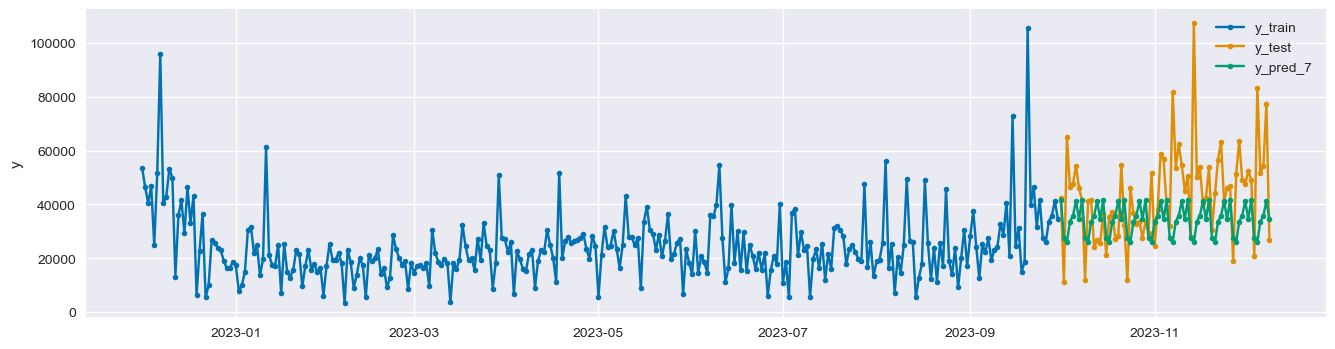

In [320]:
plot_series(y_train, y_test, y_pred_7, labels=["y_train", "y_test","y_pred_7"])

Este enfoque repite la estacionalidad semanal de la serie. Observamos que el modelo tiene dificultades para predecir la evolución de la serie temporal, sobre todo cuando se disparan las ventas. A continuación, probamos con un modelo regresor recursivo ya que predice mejor las series temporales, su funcionamiento es sencillo predice el siguiente valor basándose en los anteriores.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

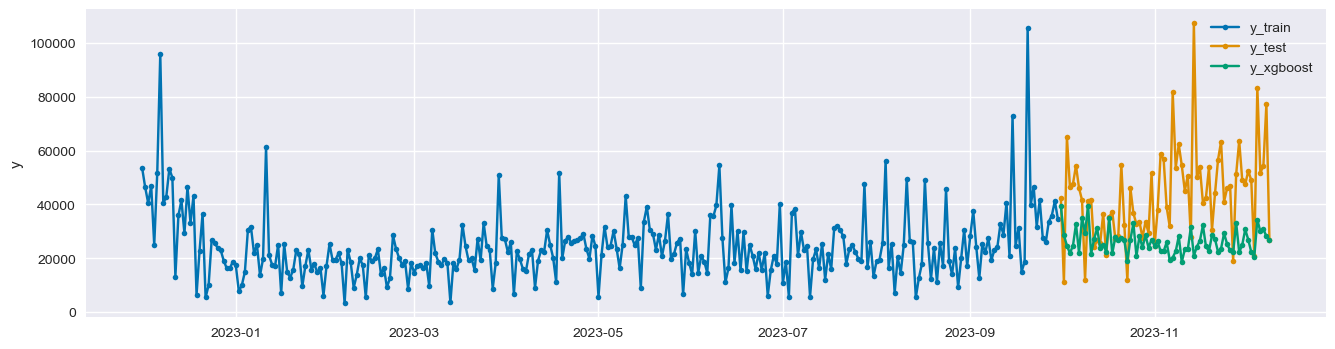

In [321]:
from xgboost import XGBRegressor
# objective='reg:squarederror': Indica que es un problema de regresión y que se usará el error cuadrático como función de pérdida.
# make_reduction. Este enfoque adapta un modelo de aprendizaje supervisado para trabajar con datos secuenciales (series temporales).
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive")
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

In [322]:
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgboost)
mae_xgb = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgb = mean_squared_error(y_test, y_pred_xgboost, squared=False)

eval_xgb = [mape_xgb, mae_xgb, rmse_xgb]
pd.DataFrame(eval_xgb, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE      0.397821
MAE   18948.389891
RMSE  24825.686624

Se observa que el modelo tiene dificultades para captar la tendencia ascendente y los valores anómalos superiores. Tanto el MAE, MAPE y RMSE aumentan sus valores respecto a anteriores modelos analizados. Una posible opción para mejorar la predicción es añadir transformadores y mejorar los hiperparámetros.

In [323]:
# Quitamos la estacionalidad.
desestacionalizador = Deseasonalizer(model="multiplicative", sp=7).fit(y_train)
y_train_desestacionalizado = desestacionalizador.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

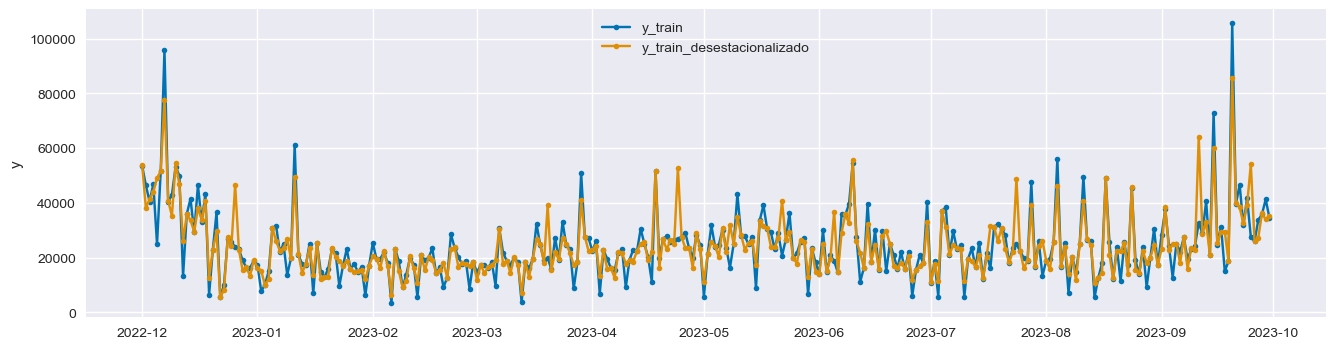

In [324]:
plot_series(y_train, y_train_desestacionalizado, labels=["y_train", "y_train_desestacionalizado"])

In [325]:
# Quitamos la tendencia.
detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1)).fit(y_train)
y_train_detrend = detrender.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

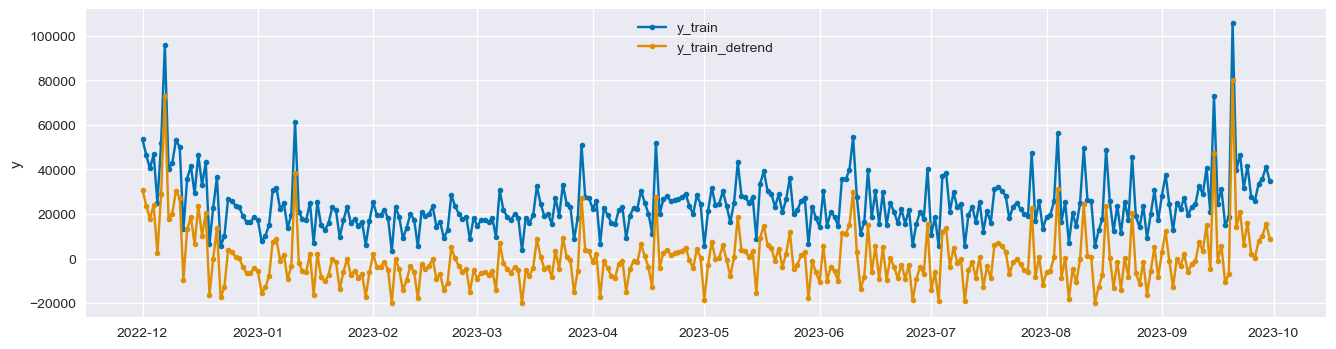

In [326]:
plot_series(y_train, y_train_detrend, labels=["y_train", "y_train_detrend"])

In [327]:
logtransform = LogTransformer().fit(y_train)
y_train_log = logtransform.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

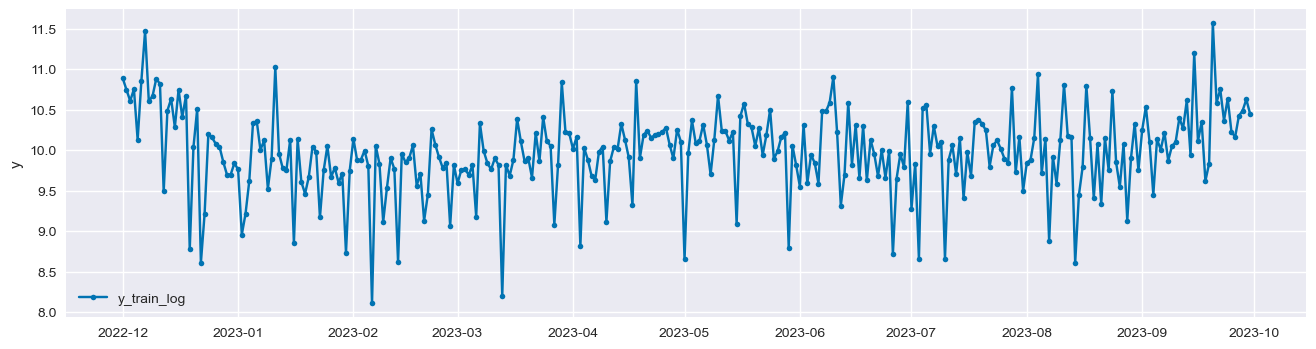

In [328]:
plot_series(y_train_log, labels=["y_train_log"])

Aplicando el logaritmo consigues que la serie sea aditiva en vez de multiplicativa. En multiplicativa las diferencias entre los primeros y últimos meses son marcadas y en esta serie vemos que el efecto de la estacionalidad es menor.

In [329]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)


forecaster  = TransformedTargetForecaster(
    [
        ("deseasonalize_year", Deseasonalizer(model="multiplicative", sp=7)),
        ('LogTransformer', LogTransformer()),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=12, scitype='tabular-regressor')),
    ]
)

forecaster.fit(y_train)
y_pred_transf = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

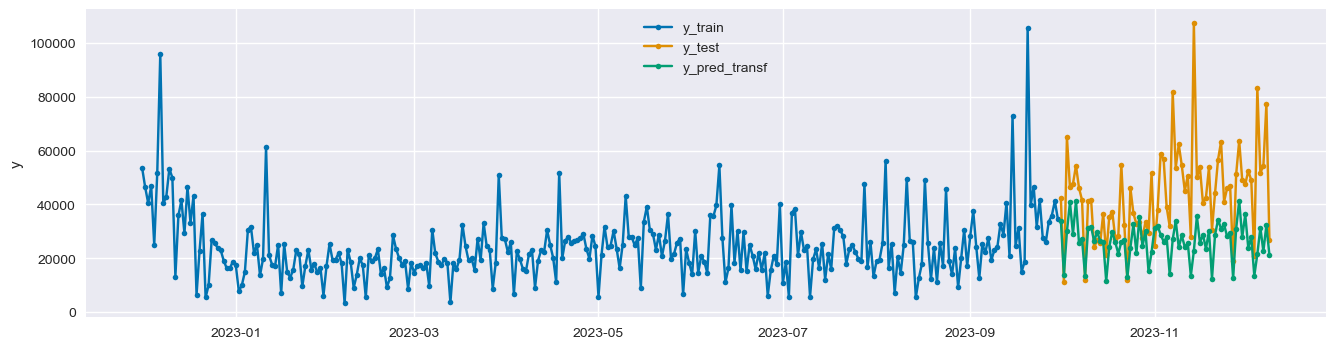

In [330]:
# Ajusta mejor que el anterior enfoque recursivo.
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

Utilizando TansformedTargetForecaster quitamos la estacionalidad, la tendencia, aplicamos logaritmo e indicamos que utilizamos el modelo XGBoost a la vez.

In [331]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=False)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE      0.357756
MAE   17624.968280
RMSE  22963.963136

Con este nuevo enfoque mejora algo la predicción respecto al anterior modelo recursivo analizado pero hay que seguir mejorandola. Vamos a probar optimizando hiperparámetros, haciendo validación cruzada y re-entrenando.

### **Evaluación cruzada**

In [332]:
# Definimos el tamaño de la muestra para hacer la validación.
validation_size = len(y_test)
validation_size

70

In [333]:
# Definimos la muestra para la validación cruzada.
# Parte con 120 días y va añadiendo 7 días en las siguientes particiones (k-fold).
cv = ExpandingWindowSplitter(initial_window=120,
                                step_length=7,
                             fh=validation_size)

In [334]:
param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}

rscv = ForecastingRandomizedSearchCV(forecaster,
                                     cv=cv,
                                     param_distributions=param_grid,
                                     n_iter=100,
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)

In [335]:
# Trabajamos con el mejor modelo obtenido.
result_cv = rscv.fit(y_train)
y_pred_transf_cv = rscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

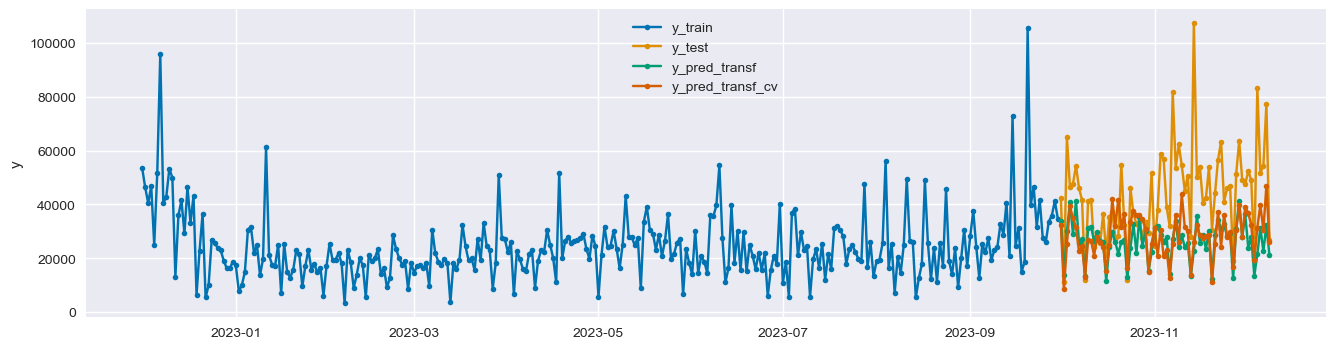

In [336]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

In [337]:
# Evaluacion

mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=False)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

eval_xgb_transf_cv
MAPE            0.338419
MAE         16559.242337
RMSE        21665.119534

Mejoramos todas las métricas optimizando los hiperparámetros.

In [338]:
# Genera una secuencia de fechas a partir del 9 de diciembre de 2023. Periods=30: Indica que se generarán 100 períodos diarios consecutivos desde el inicio de y_test (2023-10-01) hasta un mes depués del final de la serie (2024-01-08).
fhos = ForecastingHorizon(
    pd.date_range("2023-10-01", periods=100, freq="D"), 
    is_relative=False
)
fhos

ForecastingHorizon(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
               '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05',
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
 

In [339]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

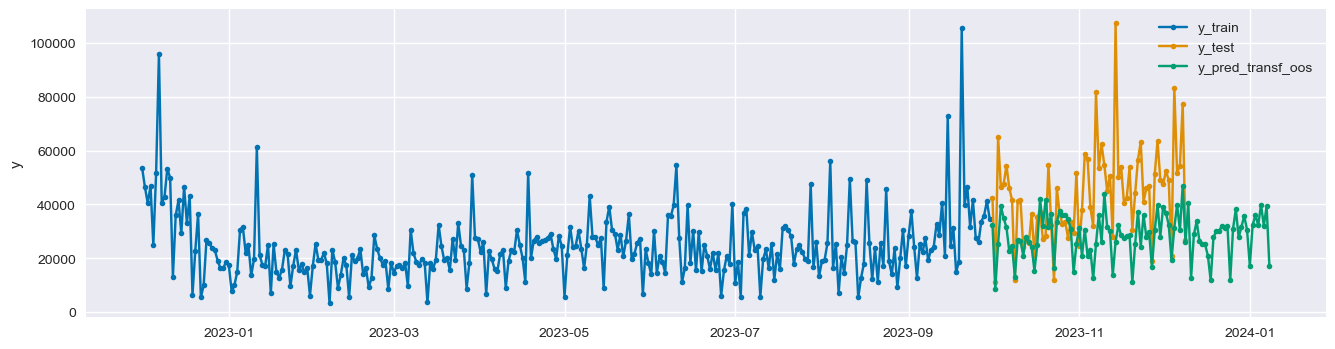

In [340]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])

El modelo tiene dificultades para capturar los valores a partir del mes de de septiembre que es cuando aumentanlas ventas y la tendencia de la serie. Realizando la predicción tomada a un mes vista según las indicaciones se observa una tendencia positiva constante con algunos picos inferiores de ventas. Las ventas en el periodo de predicción se sitúan en torno a una media de 35k con algunos picos inferiores en torno a 15k, la tendencia se observa ligeramente asecendente.

### 3.2.3 Modelo ARIMA

Con el modelo ARIMA y su extensión SARIMA que tiene en cuenta la estacionalidad de la serie podemos realizar otro análisis para la predicción de los datos de la serie.

In [341]:
df_uk.index.freq = 'D'

In [342]:
px.line(df_uk['y'])

Comenzamos averiguando si la serie es estacionaria haciendo el test de Dickey-Fuller. Como vemos el p-value es superior 0.05 por lo tanto no es estacionaria y tenemos que convertirla.

In [343]:
result_adf_pass = adfuller(df_uk['y'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_adf_pass))

{'adf': -1.3822928174107383,
 'pvalue': 0.5907351116153223,
 'usedlag': 13,
 'nobs': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7677.28909178113}

In [344]:
df_uk['diff_pass'] = df_uk['y'] - df_uk['y'].shift(1) # usa 1 por defecto
df_uk.head()

y     diff_pass
ds                                    
2022-12-01  53520.580000           NaN
2022-12-02  46422.640000  -7097.940000
2022-12-03  40483.460000  -5939.180000
2022-12-04  46808.893333   6325.433333
2022-12-05  25018.630000 -21790.263333

In [345]:
# Serie diferenciada sin tendencia.
px.line(df_uk['diff_pass'])

In [346]:
result_diff_pass = adfuller(df_uk['diff_pass'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_diff_pass))

{'adf': -8.016135357456983,
 'pvalue': 2.1364437669072303e-12,
 'usedlag': 12,
 'nobs': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7654.806394608268}

Ahora ya sí tenemos la serie estacionaria. La d del modelo ARIMA sería d=1. También tenemos que corregir la estacionalidad.

In [347]:
# Estacionalidad cada 7 días.
df_uk['seas_diff'] = df_uk['y'] - df_uk['y'].shift(7)

In [348]:
px.line(df_uk['seas_diff'])

In [349]:
result_seas = adfuller((df_uk['seas_diff']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_seas))

{'adf': -5.5066062632550095,
 'pvalue': 2.015272359493286e-06,
 'usedlag': 17,
 'nobs': 349,
 'criticalvalues': {'1%': -3.449226932880019,
  '5%': -2.869857365438656,
  '10%': -2.571201085130664},
 'icbest': 7536.473418597907}

La serie sigue siendo estacionaria por lo que podemos decir que la D=0. Seguimos con el análisis de la autocorrelación y la autocorrelación parcial.

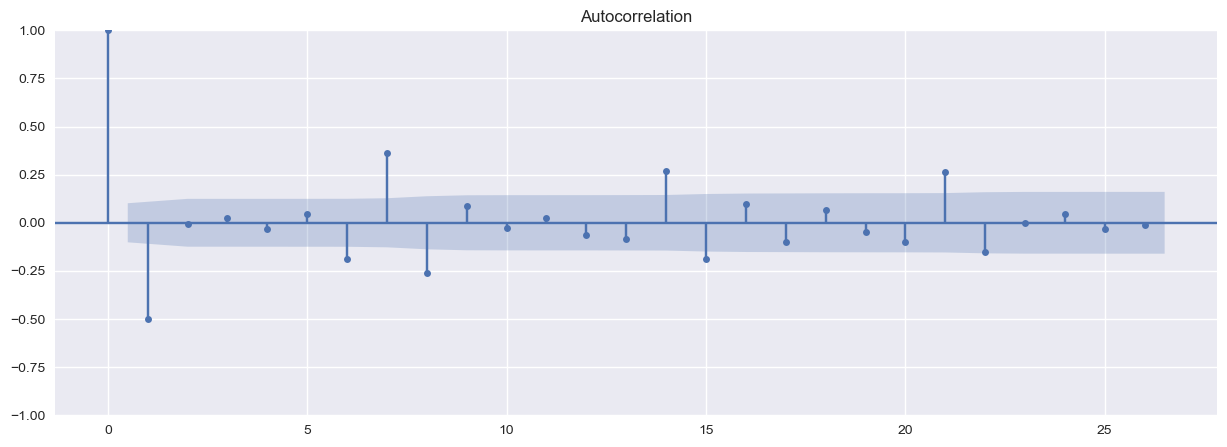

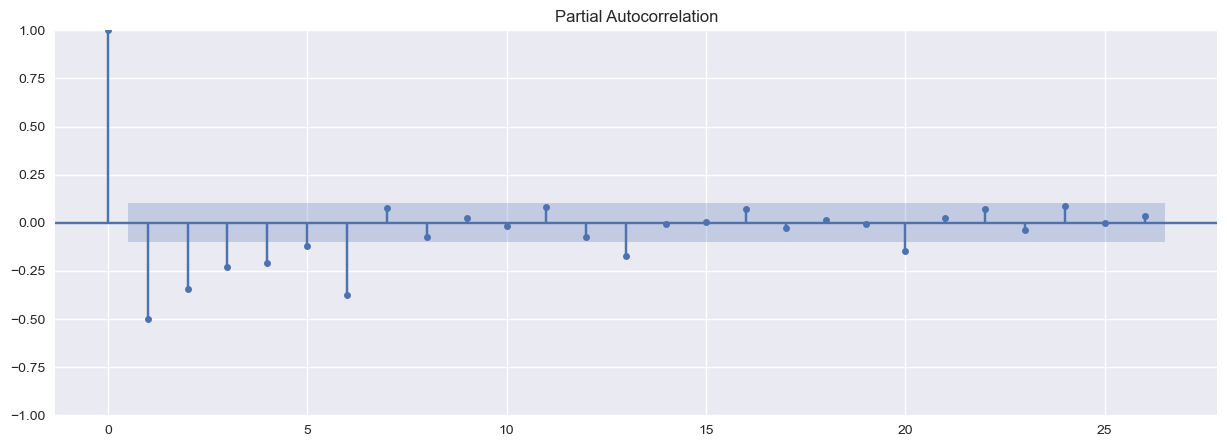

In [350]:
pax_acf = plot_acf(df_uk['diff_pass'].dropna())
pax_pacf = plot_pacf(df_uk['diff_pass'].dropna())

La p sería 6 y la q sería 7. También hay que analizar la ACF y la PACF según la perspectiva de la estacionalidad.

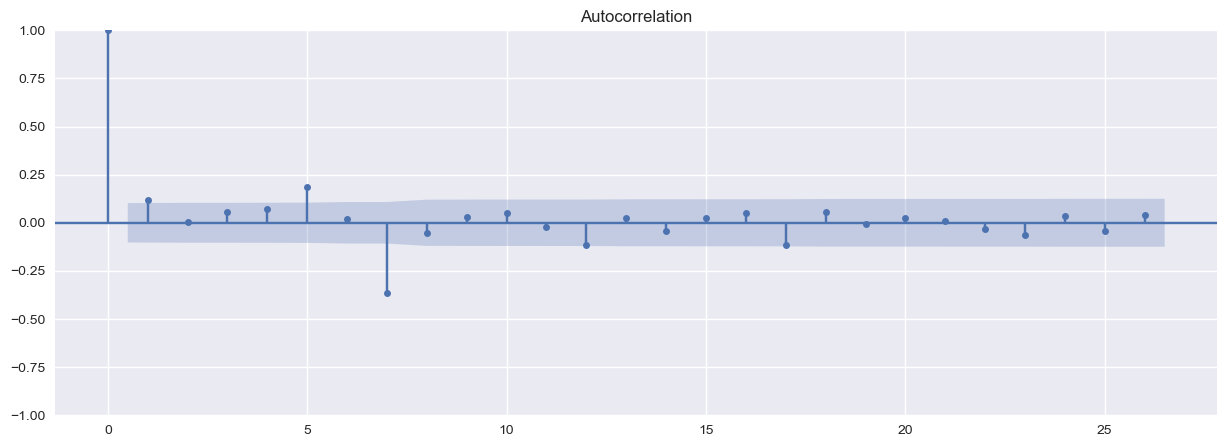

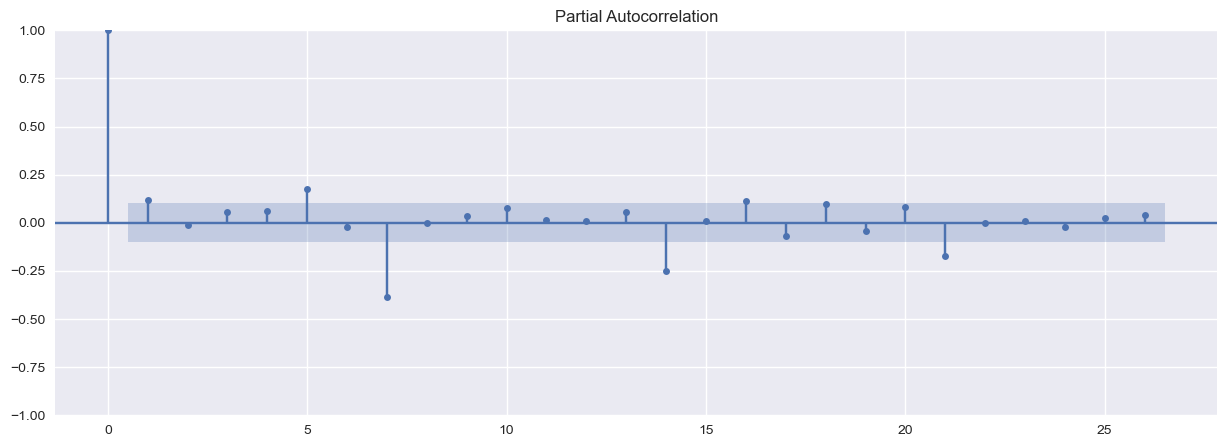

In [351]:
pax_seas_acf = plot_acf(df_uk['seas_diff'].dropna())
pax_seas_pacf = plot_pacf(df_uk['seas_diff'].dropna())

Como hay estacionalidad nos interesan los últimos dos gráficos ya que la tienen en cuenta, la P sería 7 y la Q sería 5.

### **Ajuste del modelo**

In [475]:
# Periodo estacional (s = 7): Representa un patrón que se repite cada 7 días. En order no se puede poner 7 ya que es la estacionalidad por lo que pongo 5 porque da el mejor resultado.
model_pax = SARIMAX(df_uk['y'],
                    order=(5,1,5), 
                    seasonal_order=(1, 0, 0, 7) 
                    )
result_pax = model_pax.fit()
result_pax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  374
Model:             SARIMAX(5, 1, 5)x(1, 0, [], 7)   Log Likelihood               -4028.653
Date:                            Sun, 05 Jan 2025   AIC                           8081.307
Time:                                    19:13:38   BIC                           8128.366
Sample:                                12-01-2022   HQIC                          8099.993
                                     - 12-09-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9997      0.079    -12.644      0.000      -1.155      -0.845
ar.L2         -0.6073      0.086     -7.025      0.000      -0.777      -0.438
ar.L3         -0.9690      0.077    -12.538      0.000      -1.121      -0.818
ar.L4         -0.7934      0.088     -8.991      0.000      -0.966      -0.620
ar.L5          0.1363      0.069      1.973      0.049       0.001       0.272
ma.L1          0.1508      0.064      2.357      0.018       0.025       0.276
ma.L2         -0.3495      0.068     -5.130      0.000      -0.483      -0.216
ma.L3          0.4156      0.055      7.608      0.000       0.309       0.523
ma.L4         -0.0444      0.054     -0.827      0.408      -0.150       0.061
ma.L5         -0.8966      0.059    -15.117      0.000      -1.013      -0.780
ar.S.L7        0.3099      0.055      5.597      0.000       0.201       0.418
sigma2      1.489e+08    1.4e-09   1.07e+17      0.000    1.49e+08    1.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              1042.82
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+32. Standard errors may be unstable.
"""

### **Diagnosis del modelo**

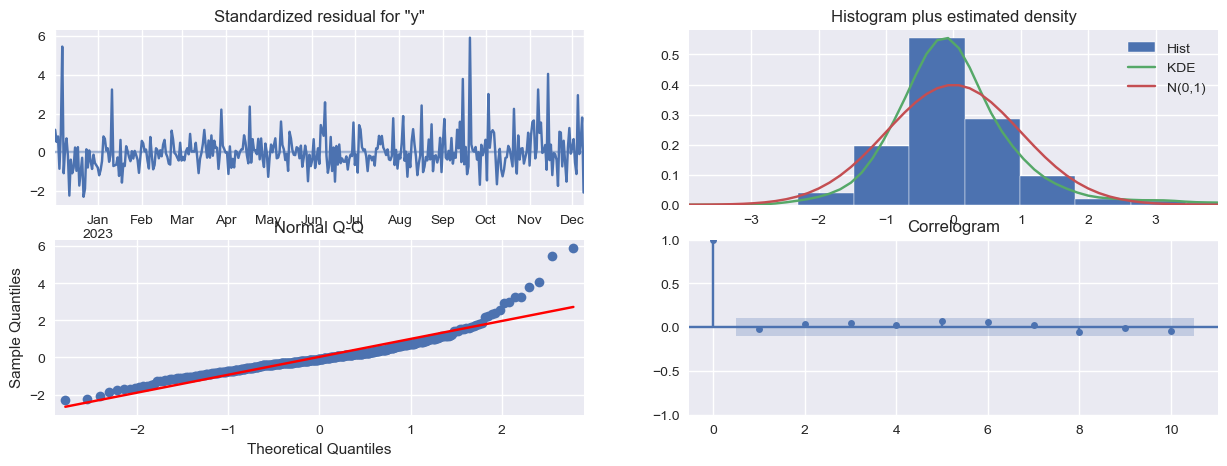

In [353]:
result_pax.plot_diagnostics()
plt.show()

Los 4 gráficos indican que los datos de nuestra serie son capturados de manera aceptable por el modelo con la salvedad de los outliers de los últimos meses de la serie que como venimos viendo tiene dificultades para captarlos. A continuación, empezamos con las predicciones.

### **Predicciones**

In [354]:
 # Paso 1: Creamos data frame para almacenar predicciones.

new_dates_test = pd.date_range('2023-12-10', freq = 'D', periods=30) # Predecimos un mes desde el fin de la serie.


df_pred = pd.DataFrame(pd.to_datetime(new_dates_test))
df_pred.columns = ['Month']
df_pred.set_index('Month', inplace = True)
df_pred['y'] = np.nan
df_pred.rename_axis(None, inplace=True)
df_pred = df_pred.sort_index(ascending=True)
df_pred.index.freq = 'D'
df_pred

y
2023-12-10 NaN
2023-12-11 NaN
2023-12-12 NaN
2023-12-13 NaN
2023-12-14 NaN
2023-12-15 NaN
2023-12-16 NaN
2023-12-17 NaN
2023-12-18 NaN
2023-12-19 NaN
2023-12-20 NaN
2023-12-21 NaN
2023-12-22 NaN
2023-12-23 NaN
2023-12-24 NaN
2023-12-25 NaN
2023-12-26 NaN
2023-12-27 NaN
2023-12-28 NaN
2023-12-29 NaN
2023-12-30 NaN
2023-12-31 NaN
2024-01-01 NaN
2024-01-02 NaN
2024-01-03 NaN
2024-01-04 NaN
2024-01-05 NaN
2024-01-06 NaN
2024-01-07 NaN
2024-01-08 NaN

In [355]:
# Paso 2: Creamos dataframe con los valores observados y las fechas futuras.

df_now_after = pd.concat([df_uk,df_pred])
display(df_now_after.head(5))
display(df_now_after.tail(5))

y     diff_pass  seas_diff
2022-12-01  53520.580000           NaN        NaN
2022-12-02  46422.640000  -7097.940000        NaN
2022-12-03  40483.460000  -5939.180000        NaN
2022-12-04  46808.893333   6325.433333        NaN
2022-12-05  25018.630000 -21790.263333        NaN

y  diff_pass  seas_diff
2024-01-04 NaN        NaN        NaN
2024-01-05 NaN        NaN        NaN
2024-01-06 NaN        NaN        NaN
2024-01-07 NaN        NaN        NaN
2024-01-08 NaN        NaN        NaN

<Axes: >

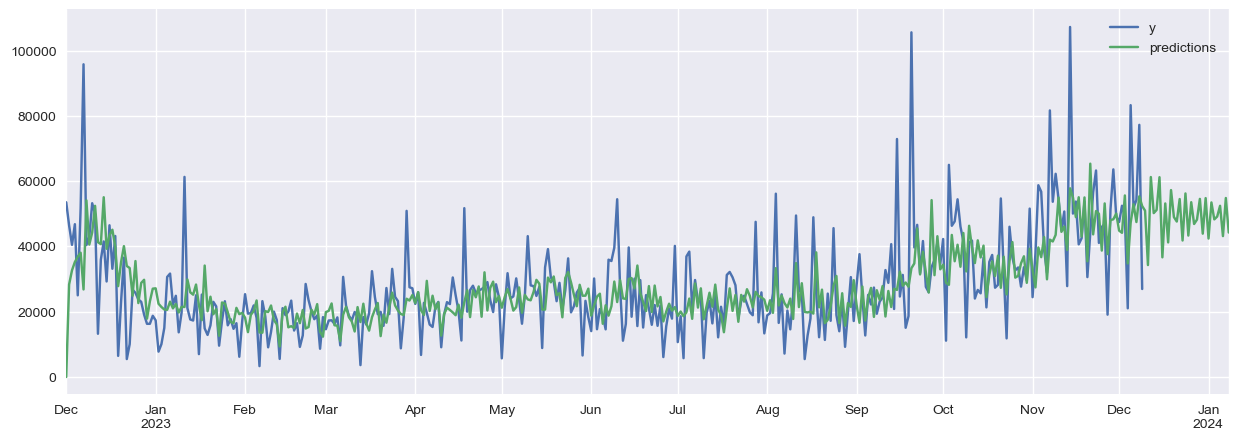

In [356]:
# Paso 3: Creamos las predicciones con el método predict.

df_now_after['predictions'] = result_pax.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y','predictions']].plot()

Aplicando logaritmos seguramente mejoremos el modelo y y podremos calcular las métricas definitivas del modelo.

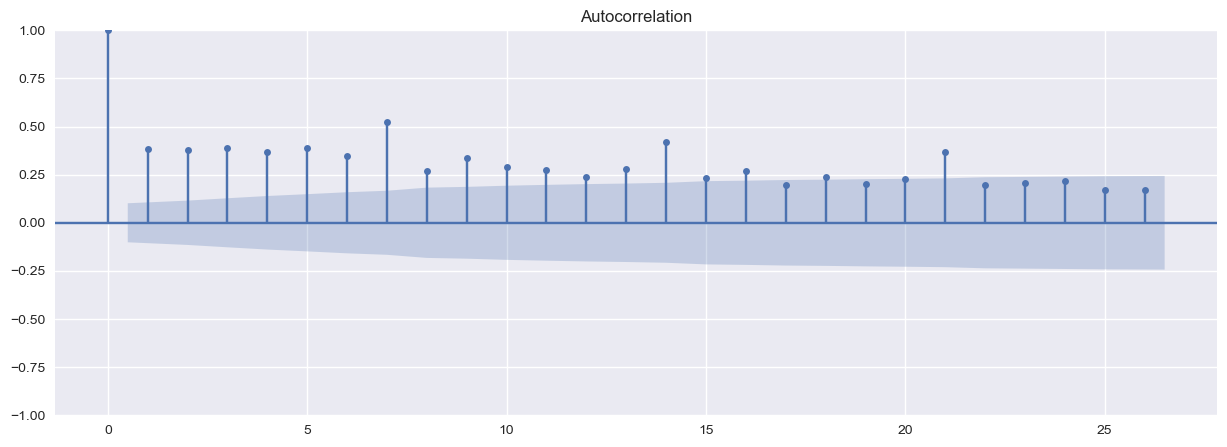

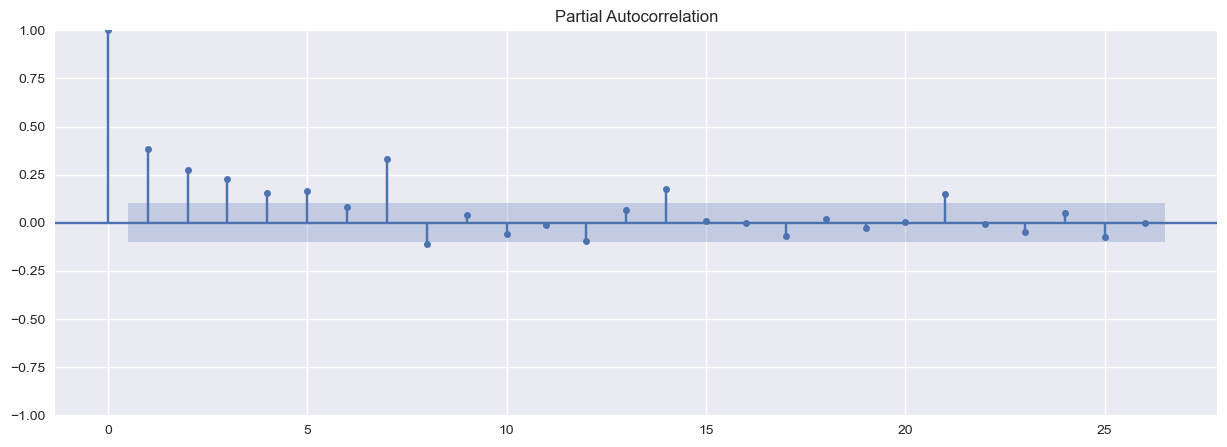

In [357]:
pax_seas_acf = plot_acf(df_uk['y'].dropna())
pax_seas_pacf = plot_pacf(df_uk['y'].dropna())

In [ ]:
df_uk['y_log'] = df_uk['y'].apply(np.log)

In [ ]:
# A lo mejor la p y la q para modelo logarítmico se saca así y no con df_uk['y']. EL resultado sería el mismo p=7 y q=7 pero puede que sea coincidencia y el código de esta celda sea el correcto.
# pax_log_acf = plot_acf(df_uk['y_log'].dropna())
# pax_lof_pacf = plot_pacf(df_uk['y_log'].dropna())

In [ ]:
# La p y la q son iguales a 5. Con d=1 da el mejor resultado.
# En order la p y la q deberían ser 7 según los gráficos pero el SARIMAX no deja poner esos valores al ser igual a la estacionalidad (7) por eso resto un valor a cada uno y da el mejor resultado con esa configuración.
# Estima el modelo
model_pax_transf = SARIMAX(df_uk['y_log'],
                    order=(6,1,6), # orden de la serie
                    seasonal_order=(1, 0, 0, 7) # orden estacional
                    )
result_pax_transf = model_pax_transf.fit()
result_pax_transf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              y_log   No. Observations:                  374
Model:             SARIMAX(6, 1, 6)x(1, 0, [], 7)   Log Likelihood                -181.946
Date:                            Sun, 05 Jan 2025   AIC                            391.891
Time:                                    19:20:38   BIC                            446.793
Sample:                                12-01-2022   HQIC                           413.692
                                     - 12-09-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3279      0.191     -6.951      0.000      -1.702      -0.953
ar.L2         -1.1385      0.380     -2.997      0.003      -1.883      -0.394
ar.L3         -0.5781      0.441     -1.312      0.190      -1.442       0.286
ar.L4         -0.0493      0.342     -0.144      0.885      -0.720       0.621
ar.L5          0.0408      0.174      0.234      0.815      -0.300       0.382
ar.L6         -0.3737      0.084     -4.445      0.000      -0.539      -0.209
ma.L1          0.6015      0.199      3.021      0.003       0.211       0.992
ma.L2          0.0186      0.233      0.080      0.936      -0.439       0.476
ma.L3         -0.5171      0.140     -3.702      0.000      -0.791      -0.243
ma.L4         -0.6374      0.082     -7.786      0.000      -0.798      -0.477
ma.L5         -0.2237      0.186     -1.204      0.229      -0.588       0.140
ma.L6          0.5207      0.165      3.162      0.002       0.198       0.843
ar.S.L7        0.0649      0.081      0.798      0.425      -0.095       0.224
sigma2         0.1517      0.010     15.039      0.000       0.132       0.172
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                19.52
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.06
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

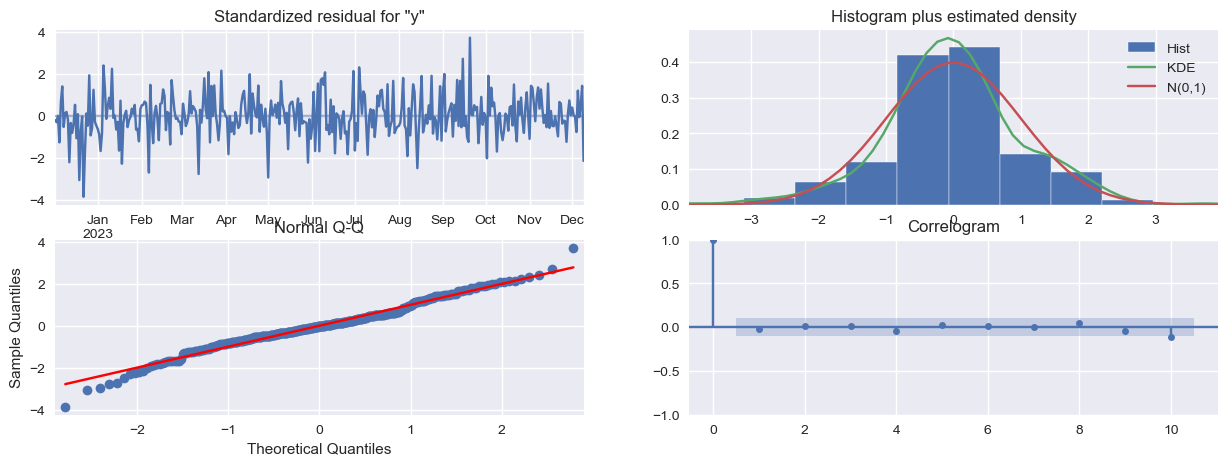

In [359]:
result_pax_transf.plot_diagnostics()
plt.show()

Los 4 gráficos indican que los datos de nuestra serie son ahora mejor capturados que en el modelo anterior.

In [360]:
df_now_after['y_log'] = df_now_after['y'].apply(np.log)
df_now_after

y     diff_pass  seas_diff   predictions      y_log
2022-12-01  53520.580000           NaN        NaN      0.000000  10.887822
2022-12-02  46422.640000  -7097.940000        NaN  28345.267238  10.745543
2022-12-03  40483.460000  -5939.180000        NaN  32674.484693  10.608649
2022-12-04  46808.893333   6325.433333        NaN  35228.763034  10.753828
2022-12-05  25018.630000 -21790.263333        NaN  36842.263622  10.127376
...                  ...           ...        ...           ...        ...
2024-01-04           NaN           NaN        NaN  49142.914699        NaN
2024-01-05           NaN           NaN        NaN  52439.791019        NaN
2024-01-06           NaN           NaN        NaN  43159.668251        NaN
2024-01-07           NaN           NaN        NaN  54828.443191        NaN
2024-01-08           NaN           NaN        NaN  44261.544934        NaN

[404 rows x 5 columns]

<Axes: >

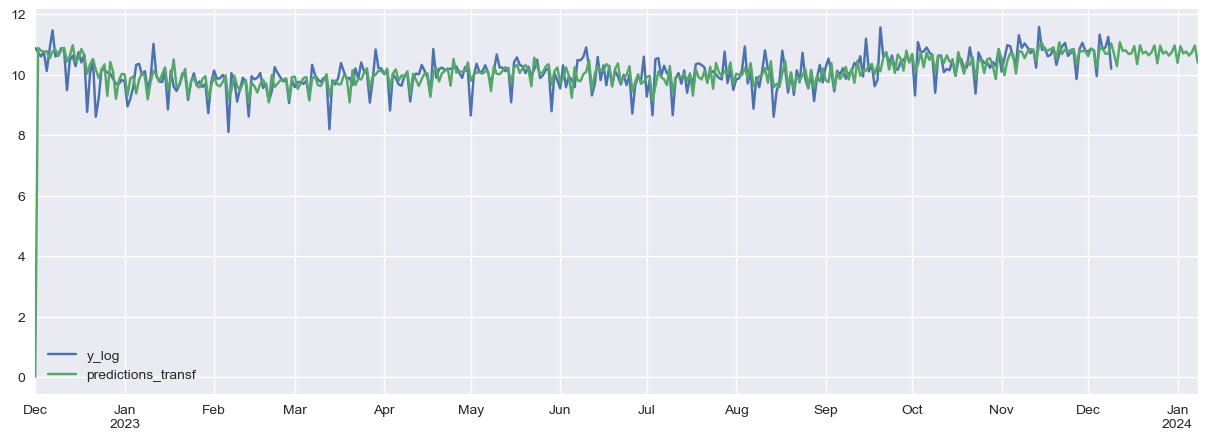

In [361]:
df_now_after['predictions_transf'] = result_pax_transf.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y_log','predictions_transf']].plot()

In [362]:
# Es necesario aplicar la función exponencial a la logarítmica para poder comparar los valores con la serie original.
df_now_after['pred_transf_rev'] = df_now_after['predictions_transf'].apply(np.exp)
df_now_after

y     diff_pass  seas_diff   predictions      y_log  \
2022-12-01  53520.580000           NaN        NaN      0.000000  10.887822   
2022-12-02  46422.640000  -7097.940000        NaN  28345.267238  10.745543   
2022-12-03  40483.460000  -5939.180000        NaN  32674.484693  10.608649   
2022-12-04  46808.893333   6325.433333        NaN  35228.763034  10.753828   
2022-12-05  25018.630000 -21790.263333        NaN  36842.263622  10.127376   
...                  ...           ...        ...           ...        ...   
2024-01-04           NaN           NaN        NaN  49142.914699        NaN   
2024-01-05           NaN           NaN        NaN  52439.791019        NaN   
2024-01-06           NaN           NaN        NaN  43159.668251        NaN   
2024-01-07           NaN           NaN        NaN  54828.443191        NaN   
2024-01-08           NaN           NaN        NaN  44261.544934        NaN   

            predictions_transf  pred_transf_rev  
2022-12-01            0.000000         1.000000  
2022-12-02           10.887820     53520.475857  
2022-12-03           10.801512     49094.971669  
2022-12-04           10.758997     47051.447941  
2022-12-05           10.781799     48136.624426  
...                        ...              ...  
2024-01-04           10.773543     47740.870315  
2024-01-05           10.634048     41524.863437  
2024-01-06           10.748354     46553.323173  
2024-01-07           10.965874     57865.321575  
2024-01-08           10.406548     33075.499959  

[404 rows x 7 columns]

<Axes: >

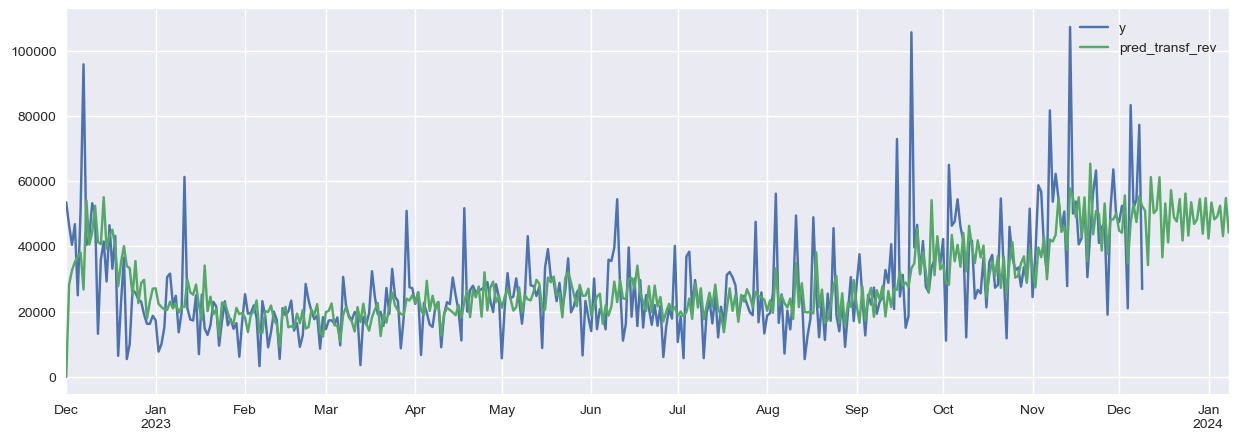

In [363]:
df_now_after['pred_transf_rev'] = result_pax.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y','pred_transf_rev']].plot()

El modelo capta correctamente una tendencia más o menos estable hasta el mes de septimbre. A partir de ahí tiene dificultades para captar los picos superiores de ventas de United Kingdom. Para el mes en predicción indica que las ventas serían estables y sin picos de importancia. 

In [364]:
df_now_after_eval = df_now_after.dropna()
df_now_after_eval

y     diff_pass     seas_diff   predictions      y_log  \
2022-12-08  40409.150000 -55385.040000 -13111.430000  54109.069669  10.606812   
2022-12-09  42939.130000   2529.980000  -3483.510000  40558.356495  10.667539   
2022-12-10  53229.500000  10290.370000  12746.040000  44251.121458  10.882368   
2022-12-11  49949.876667  -3279.623333   3140.983333  52434.343718  10.818775   
2022-12-12  13238.990000 -36710.886667 -11779.640000  41284.488525   9.490922   
...                  ...           ...           ...           ...        ...   
2023-12-05  83274.820000  62235.560000  32067.300000  47266.366758  11.329902   
2023-12-06  51767.130000 -31507.690000 -11832.980000  52922.207298  10.854511   
2023-12-07  54270.500000   2503.370000   5086.760000  47470.852435  10.901736   
2023-12-08  77242.100000  22971.600000  29785.850000  55346.838035  11.254700   
2023-12-09  26956.270000 -50285.830000 -25501.350000  52360.849368  10.201971   

            predictions_transf  pred_transf_rev  
2022-12-08           10.840295     54109.069669  
2022-12-09           10.621792     40558.356495  
2022-12-10           10.805651     44251.121458  
2022-12-11           10.896240     52434.343718  
2022-12-12           10.431061     41284.488525  
...                        ...              ...  
2023-12-05           10.864567     47266.366758  
2023-12-06           10.881063     52922.207298  
2023-12-07           10.697396     47470.852435  
2023-12-08           10.699300     55346.838035  
2023-12-09           11.042313     52360.849368  

[367 rows x 7 columns]

In [365]:
# Utilizo el intervalo [297:403] para ajustar los valores con el y_test.
mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, df_now_after_eval['pred_transf_rev'][297:403])
mae_xgb_transf_cv = mean_absolute_error(y_test, df_now_after_eval['pred_transf_rev'][297:403])
rmse_xgb_transf_cv = mean_squared_error(y_test, df_now_after_eval['pred_transf_rev'][297:403], squared=False)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

eval_xgb_transf_cv
MAPE            0.285654
MAE         10650.869612
RMSE        14539.689680

Aplicando logaritmos obtenemos el mejor modelo SARIMAX de todos los estudiados anteriormente. Eso se debe a que estabiliza la varianza y reduce el efecto de los outliers positivos que en esta serie distorsionaban los modelos analizados.

Analizados ya todos los modelos de loas ventas de United Kingdom el modelo con mejores métricas es el multiplicativo de Prophet que presenta los menores MAE (7405.92) y RMSE (10347.29). El modelo que presenta mejor MAPE (0.28) es el modelo SARIMAX aplicando logaritmos.

Como hipótesis las diferencias entre la predicción y los resultados a partir de septiembre se puede deber a promociones en esas fechas o que sus ventas sean mayores de normal en esas fechas dado que puedan vender productos para Navidad o que tengan relación con el invierno.

# 4. Análisis por países
### **Ventas del resto de países**

In [366]:
df

invoiceno stockcode       date         country  totalsales  \
0         536365     21730 2022-12-01  United Kingdom       25.50   
1         536365     22752 2022-12-01  United Kingdom       15.30   
2         536365     71053 2022-12-01  United Kingdom       20.34   
3         536365    84029E 2022-12-01  United Kingdom       20.34   
4         536365    84029G 2022-12-01  United Kingdom       20.34   
...          ...       ...        ...             ...         ...   
394325    581587     22730 2023-12-09          France       15.00   
394326    581587     23254 2023-12-09          France       16.60   
394327    581587     23255 2023-12-09          France       16.60   
394328    581587     23256 2023-12-09          France       16.60   
394329   A563185         B 2023-08-12  United Kingdom    11062.06   

                                description  
0         GLASS STAR FROSTED T-LIGHT HOLDER  
1              SET 7 BABUSHKA NESTING BOXES  
2                       WHITE METAL LANTERN  
3            RED WOOLLY HOTTIE WHITE HEART.  
4       KNITTED UNION FLAG HOT WATER BOTTLE  
...                                     ...  
394325           ALARM CLOCK BAKELIKE IVORY  
394326         CHILDRENS CUTLERY DOLLY GIRL  
394327      CHILDRENS CUTLERY CIRCUS PARADE  
394328           CHILDRENS CUTLERY SPACEBOY  
394329                      Adjust bad debt  

[394330 rows x 6 columns]

In [367]:
df['totalsales'].groupby(df['country']).sum()


country
Belgium             36806.580
EIRE               261750.070
France             192274.730
Germany            210139.590
Italy               14989.270
Netherlands        261986.880
Portugal            30933.430
Spain               55980.350
Sweden              36024.690
United Kingdom    8555662.571
Name: totalsales, dtype: float64

In [368]:
df['country'].value_counts(normalize=True)

country
United Kingdom    0.931517
Germany           0.017853
France            0.016433
EIRE              0.015543
Spain             0.004803
Netherlands       0.004542
Belgium           0.004037
Portugal          0.002919
Italy             0.001468
Sweden            0.000885
Name: proportion, dtype: float64

Analizando la suma de las ventas por países observamos que United Kingdom posee el 93% de los filas y la gran mayor parte del total de ventas por eso hicimos anteriormente el análisis para las ventas de UK. Dada la gran diferencia que hay con el resto de países decido agrupar el resto de países y analizar su serie temporal.

In [369]:
rest_countries = ['Germany', 'France', 'EIRE', 'Spain', 'Netherlands', 'Belgium', 'Portugal', 'Italy', 'Sweden']
df_rest = df.query("country in @rest_countries")
df_rest = df_rest.sort_values(by='date')
df_rest

invoiceno stockcode       date  country  totalsales  \
26        536370     10002 2022-12-01   France       40.80   
792       536527     47421 2022-12-01  Germany       10.08   
793       536527     84347 2022-12-01  Germany       15.30   
794       536527    84569B 2022-12-01  Germany       15.00   
795       536527     84945 2022-12-01  Germany       10.20   
...          ...       ...        ...      ...         ...   
393792    581494     23367 2023-12-09  Germany       15.60   
393791    581494     23084 2023-12-09  Germany       42.96   
393790    581494     22730 2023-12-09  Germany       15.00   
394179    581570     21914 2023-12-09  Germany       15.00   
394328    581587     23256 2023-12-09   France       16.60   

                                description  
26               INFLATABLE POLITICAL GLOBE  
792     ASSORTED COLOUR LIZARD SUCTION HOOK  
793     ROTATING SILVER ANGELS T-LIGHT HLDR  
794          PACK 3 FIRE ENGINE/CAR PATCHES  
795      MULTI COLOUR SILVER T-LIGHT HOLDER  
...                                     ...  
393792       SET 12 COLOUR PENCILS SPACEBOY  
393791                   RABBIT NIGHT LIGHT  
393790           ALARM CLOCK BAKELIKE IVORY  
394179                BLUE HARMONICA IN BOX  
394328           CHILDRENS CUTLERY SPACEBOY  

[27005 rows x 6 columns]

In [370]:
df_rest = df_rest[['date', 'totalsales']]
df_rest.columns = ['ds', 'y']
df_rest

ds      y
26     2022-12-01  40.80
792    2022-12-01  10.08
793    2022-12-01  15.30
794    2022-12-01  15.00
795    2022-12-01  10.20
...           ...    ...
393792 2023-12-09  15.60
393791 2023-12-09  42.96
393790 2023-12-09  15.00
394179 2023-12-09  15.00
394328 2023-12-09  16.60

[27005 rows x 2 columns]

In [371]:
# Agrupamos las ventas por días y vemos que hay algunos días que no aparecen en el df, por ejemplo el 2022-12-04.
df_rest = df_rest.groupby('ds', as_index=False)['y'].sum()
df_rest

ds         y
0   2022-12-01   1715.06
1   2022-12-02    167.90
2   2022-12-03   4471.82
3   2022-12-05   3811.07
4   2022-12-06   1343.99
..         ...       ...
280 2023-12-05   1963.05
281 2023-12-06   3035.14
282 2023-12-07  18442.79
283 2023-12-08   2335.88
284 2023-12-09   1933.57

[285 rows x 2 columns]

In [372]:
# Para solucionar la falta de días en el periodo creamos un data range desde la primera fecha a la última de la serie de df_rest para tener todos los días en la serie.
date_range = pd.date_range(start='2022-12-01', end='2023-12-09', freq='D')
date_range

DatetimeIndex(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10',
               ...
               '2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-09'],
              dtype='datetime64[ns]', length=374, freq='D')

In [373]:
df_rest = df_rest.set_index('ds')
df_rest = df_rest.reindex(date_range)
df_rest

y
2022-12-01   1715.06
2022-12-02    167.90
2022-12-03   4471.82
2022-12-04       NaN
2022-12-05   3811.07
...              ...
2023-12-05   1963.05
2023-12-06   3035.14
2023-12-07  18442.79
2023-12-08   2335.88
2023-12-09   1933.57

[374 rows x 1 columns]

In [374]:
df_rest['y'] = df_rest['y'].fillna(df_rest['y'].rolling(window=12, min_periods=1).mean())

In [375]:
df_rest = df_rest.reset_index()
df_rest.columns = ['ds', 'y']
df_rest

ds         y
0   2022-12-01   1715.06
1   2022-12-02    167.90
2   2022-12-03   4471.82
3   2022-12-04   2118.26
4   2022-12-05   3811.07
..         ...       ...
369 2023-12-05   1963.05
370 2023-12-06   3035.14
371 2023-12-07  18442.79
372 2023-12-08   2335.88
373 2023-12-09   1933.57

[374 rows x 2 columns]

In [376]:
px.line(df_rest, x = 'ds', y = 'y')

La serie temporal del resto de países presenta a lo largo de los meses una tendencia estable con unos pocos días en los que se multiplican las ventas (outliers) y a partir de octubre aumenta un poco la tendencia y hay mayor concentración de outliers.

## 4.1 Análisis descriptivo

In [377]:
df_rest.describe()

ds             y
count                            374    374.000000
mean   2023-06-05 12:00:00.000000256   3802.716470
min              2022-12-01 00:00:00     33.900000
25%              2023-03-04 06:00:00   1601.262500
50%              2023-06-05 12:00:00   2775.157500
75%              2023-09-06 18:00:00   4560.585000
max              2023-12-09 00:00:00  31177.740000
std                              NaN   4025.096329

### 4.1.1 Modelo aditivo

In [378]:
# Asumimos estacionalidad semanal que ya confirmaremos más adelante.
result = seasonal_decompose(df_rest['y'], model = 'additive', period = 7)
result

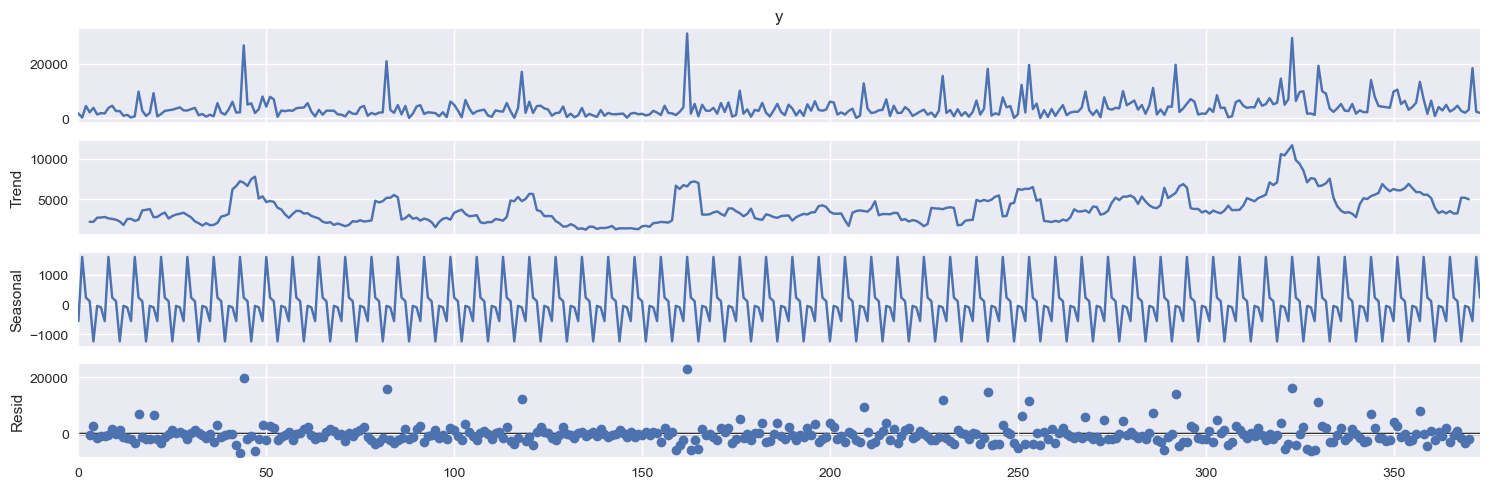

In [379]:
result.plot()
plt.show()

La tendencia es constante con algo de aumento en los últimos meses con algunos picos que se repiten cada cierto tiempo. En cuanto a la estacionalidad semanal se confirma viendo el gráfico. Mirando los residuos es hacia el final de la serie cuando hay más outliers y le cuesta más capatar los valores correctos.

In [380]:
df_ad = df_rest.copy()
df_ad['observed'] = result.observed
df_ad['trend'] = result.trend
df_ad['seasonal'] = result.seasonal
df_ad['residual'] = result.resid
df_ad

ds         y  observed        trend     seasonal     residual
0   2022-12-01   1715.06   1715.06          NaN  -553.680187          NaN
1   2022-12-02    167.90    167.90          NaN  1587.844751          NaN
2   2022-12-03   4471.82   4471.82          NaN   228.505019          NaN
3   2022-12-04   2118.26   2118.26  2209.540000   110.227313  -201.507313
4   2022-12-05   3811.07   3811.07  2208.624286 -1232.181997  2834.627711
..         ...       ...       ...          ...          ...          ...
369 2023-12-05   1963.05   1963.05  5182.521857   -43.579184 -3175.892673
370 2023-12-06   3035.14   3035.14  4997.863286   -97.135715 -1865.587570
371 2023-12-07  18442.79  18442.79          NaN  -553.680187          NaN
372 2023-12-08   2335.88   2335.88          NaN  1587.844751          NaN
373 2023-12-09   1933.57   1933.57          NaN   228.505019          NaN

[374 rows x 6 columns]

In [381]:
df_ad['estimated'] = df_ad['trend'] + df_ad['seasonal']
df_rest_matrix = df_ad[['y', 'estimated']].copy()
df_rest_matrix = df_rest_matrix[df_rest_matrix['estimated'].isna() == False]
df_uk_matrix

y     estimated
3    46808.893333  51398.196117
4    25018.630000  49524.591636
5    51731.610000  49027.507290
6    95794.190000  50848.505199
7    40409.150000  51297.010097
..            ...           ...
366  52457.620000  52287.386308
367  48992.997000  50597.026640
368  21039.260000  51323.163589
369  83274.820000  55578.844957
370  51767.130000  51935.930009

[368 rows x 2 columns]

In [382]:
px.line(df_uk_matrix)

La estimación es más acertada en el inicio de la serie, según se va avanzando le cuesta más capturar los valores. Procedemos a calcular las métricas. 

In [383]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt

In [384]:
print('El error absoluto medio (MAE) es:', mean_absolute_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error medio cuadrado (MSE) es:', mean_squared_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error cuadrático medio (RMSE) es:', sqrt(mean_squared_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y'])))

El error absoluto medio (MAE) es: 2185.001601550663
El error medio cuadrado (MSE) es: 12091669.420387087
El error cuadrático medio (RMSE) es: 3477.3077833845955


In [385]:
print('El r cuadrado (R2) es:', r2_score(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error porcentual absoluto medio (MAPE) es:', mean_absolute_percentage_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))

El r cuadrado (R2) es: 0.23346803178099096
El error porcentual absoluto medio (MAPE) es: 1.5742039133640557


Las métricas son altas sobre todo el MAPE, le cuesta captar los valores de la serie. A contnuación, vamos a analizar el multiplicativo por si fuera mejor.

### 4.1.2 Modelo multiplicativo

In [386]:
result = seasonal_decompose(df_rest['y'], model = 'multiplicative', period = 7)
result

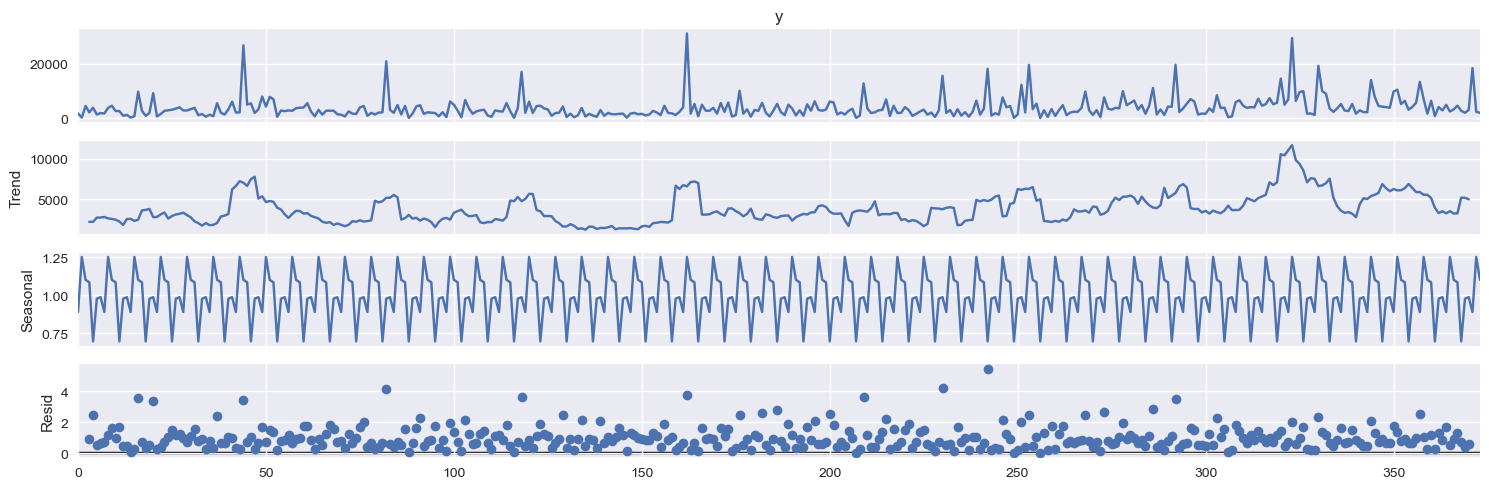

In [387]:
result.plot()
plt.show()

Con el modelo multiplicativo la estacionalidad y tendencia tienen el mismo comportamiento y en cuanto a los errores se distribuyen de la misma manera durante toda la serie.

In [388]:
df_mul = df_rest.copy()
df_mul['observed'] = result.observed
df_mul['trend'] = result.trend
df_mul['seasonal'] = result.seasonal
df_mul['residual'] = result.resid
df_mul

ds         y  observed        trend  seasonal  residual
0   2022-12-01   1715.06   1715.06          NaN  0.891297       NaN
1   2022-12-02    167.90    167.90          NaN  1.253766       NaN
2   2022-12-03   4471.82   4471.82          NaN  1.102853       NaN
3   2022-12-04   2118.26   2118.26  2209.540000  1.086676  0.882220
4   2022-12-05   3811.07   3811.07  2208.624286  0.697843  2.472678
..         ...       ...       ...          ...       ...       ...
369 2023-12-05   1963.05   1963.05  5182.521857  0.978615  0.387060
370 2023-12-06   3035.14   3035.14  4997.863286  0.988950  0.614073
371 2023-12-07  18442.79  18442.79          NaN  0.891297       NaN
372 2023-12-08   2335.88   2335.88          NaN  1.253766       NaN
373 2023-12-09   1933.57   1933.57          NaN  1.102853       NaN

[374 rows x 6 columns]

In [389]:
df_mul['estimated'] = df_mul['trend'] + df_mul['seasonal']
df_rest_matrix = df_mul[['y', 'estimated']].copy()
df_rest_matrix = df_rest_matrix[df_rest_matrix['estimated'].isna() == False]
df_rest_matrix

y    estimated
3    2118.260  2210.626676
4    3811.070  2209.322128
5    1343.990  2722.700043
6    1838.680  2737.237522
7    1708.650  2805.805265
..        ...          ...
366  3226.180  3228.651853
367  4583.633  3257.832819
368  2690.980  5194.665414
369  1963.050  5183.500472
370  3035.140  4998.852236

[368 rows x 2 columns]

In [390]:
px.line(df_rest_matrix)

Se aprecia que el modelo multiplicativo se adapta peor que el aditivo. Vamos a confirmarlo con las métricas.

In [391]:
print('El error abosulo medio (MAE) es:', mean_absolute_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error medio cuadrado (MSE) es:', mean_squared_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error cuadrático medio (RMSE) es:', sqrt(mean_squared_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y'])))

El error abosulo medio (MAE) es: 2182.18502461257
El error medio cuadrado (MSE) es: 12720565.16541258
El error cuadrático medio (RMSE) es: 3566.590131401782


In [392]:
print('El r cuadrado (R2) es:', r2_score(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))
print('El error porcentual absoluto medio (MAPE) es:', mean_absolute_percentage_error(y_pred = df_rest_matrix['estimated'], y_true = df_rest_matrix['y']))

El r cuadrado (R2) es: 0.19360019579581556
El error porcentual absoluto medio (MAPE) es: 1.8588043282150672


Efectivamente las métricas del aditivo son mejores que las del multiplicativo sobre todo el R^2 y el MAPE por lo que capta mejor las ventas. Esto quiere decir que las variaciones alrededor de la tendencia no varían con el nivel de la serie temporal.

### 4.1.3 Autocorrelación y autocorrelación parcial

In [393]:
# Cálculo de la autocorrelación con lag=1.
df_pax_corr = df_rest['y'].autocorr()
df_pax_corr

0.0652094764154404

In [394]:
# Calculo de la autocorrelación hasta un lag máximo.
autocorr_values = acf(df_rest['y'], nlags=36)
autocorr_values

array([ 1.        ,  0.06516873,  0.06634967,  0.04551136,  0.05726836,
        0.08155472,  0.10537063,  0.12933196,  0.01348401,  0.08684822,
       -0.01817018,  0.07154076,  0.02813525,  0.02230544,  0.10096884,
        0.01574121, -0.03284007, -0.01557503,  0.00490038, -0.02411084,
        0.02519402,  0.11878562, -0.01339254,  0.02189768,  0.04258419,
        0.02234691, -0.00730581,  0.11710248,  0.08652895, -0.02681362,
        0.01667413,  0.06369242,  0.03078552,  0.10259214,  0.05160823,
        0.03902042,  0.04692083])

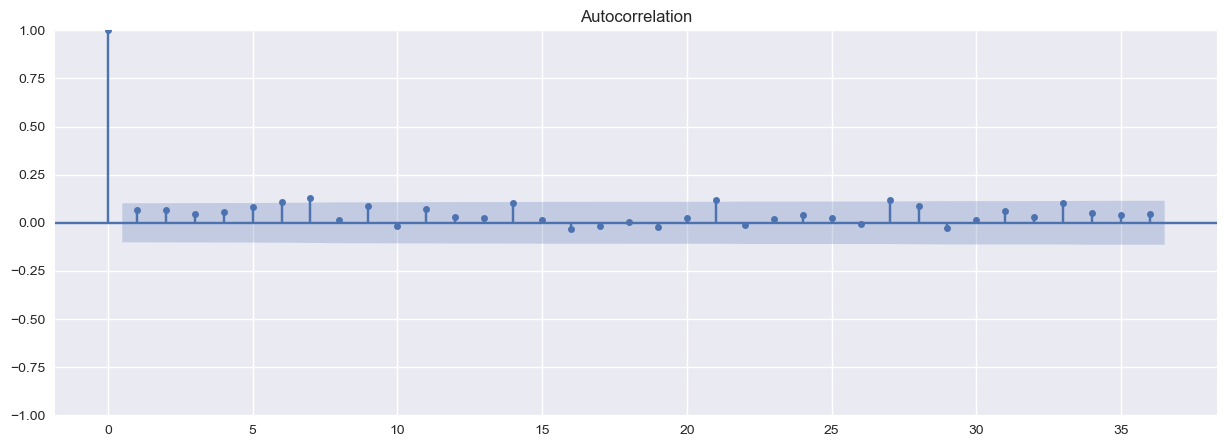

In [395]:
plot_acf(df_rest['y'], lags = 36)
plt.show()

El análisis de correlación refleja una estacionalidad semanal en las ventas ya que se oberva una ligera correlación cada 7 días.

In [396]:
# Calcular la autocorrelación parcial hasta un lag máximo.
pautocorr_values = pacf(df_rest['y'], nlags=36)
pautocorr_values

array([ 1.        ,  0.06534344,  0.06270435,  0.03800764,  0.04914853,
        0.07203788,  0.09193563,  0.11147767, -0.01626526,  0.06529977,
       -0.04871598,  0.04726619, -0.00380706, -0.01002044,  0.08272501,
       -0.00685186, -0.06484652, -0.02164054, -0.02007669, -0.03132199,
        0.00695956,  0.12314302, -0.01591162,  0.01961627,  0.05665061,
        0.0114151 , -0.02984616,  0.1135412 ,  0.05919002, -0.05837355,
       -0.0054076 ,  0.07355243, -0.01581539,  0.08791967,  0.01276035,
       -0.01062187,  0.02613388])

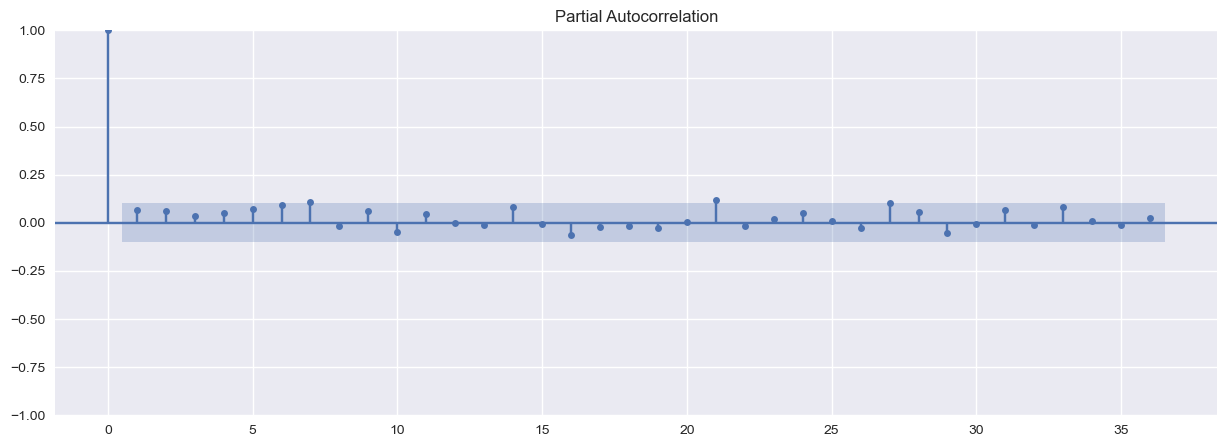

In [397]:
# La autocorrelación parcial muestra el efecto de un instante concreto (mes concreto) eliminando los efectos de los instantes intermedios.
plot_pacf(df_rest['y'], lags = 36)
plt.show()

La autocorrelación parcial sigue mostrando estacionalidad semanal.

### 4.1.4 Procesos estacionarias

In [398]:
result = adfuller(df_rest['y'])
print('p-value of the Dickey-Fuller test: %f' % result[1])

p-value of the Dickey-Fuller test: 0.000000


In [399]:
px.line(df_rest, x = 'ds', y = 'y')

El test de Dickey-Fuller muestra un resultado de 0.00 por lo que es totalmente estacionaria la serie temporal del resto de países.

## 4.2 Desarrollo de métodos, análisis de resultados y selección de modelo

### 4.2.1 Prophet

Vamos a utilizar la herramienta Prophet para la predicción de la serie temporal.

In [400]:
m = Prophet(weekly_seasonality=True)
m.fit(df_rest)

17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing


In [401]:
# Proyectamos a un mes vista que es nuestro objetivo de predicción de ventas.

future_df = m.make_future_dataframe(periods=30, freq='D') 
future_df

ds
0   2022-12-01
1   2022-12-02
2   2022-12-03
3   2022-12-04
4   2022-12-05
..         ...
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

[404 rows x 1 columns]

In [402]:
forecast_df = m.predict(future_df)

display(forecast_df.head(5))
display(forecast_df.tail(5))

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2022-12-01  2752.433243 -2316.264871  7165.241099  2752.433243  2752.433243   
1 2022-12-02  2755.769838  -511.430876  8878.337834  2755.769838  2755.769838   
2 2022-12-03  2759.106433 -2013.642265  7920.826486  2759.106433  2759.106433   
3 2022-12-04  2762.443027 -2161.875173  7810.401563  2762.443027  2762.443027   
4 2022-12-05  2765.779622 -3380.985450  6537.797400  2765.779622  2765.779622   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0     -308.104662           -308.104662           -308.104662  -308.104662   
1     1408.548125           1408.548125           1408.548125  1408.548125   
2      172.411382            172.411382            172.411382   172.411382   
3       81.720549             81.720549             81.720549    81.720549   
4    -1217.268309          -1217.268309          -1217.268309 -1217.268309   

   weekly_lower  weekly_upper  multiplicative_terms  \
0   -308.104662   -308.104662                   0.0   
1   1408.548125   1408.548125                   0.0   
2    172.411382    172.411382                   0.0   
3     81.720549     81.720549                   0.0   
4  -1217.268309  -1217.268309                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  2444.328580  
1                         0.0                         0.0  4164.317963  
2                         0.0                         0.0  2931.517814  
3                         0.0                         0.0  2844.163577  
4                         0.0                         0.0  1548.511313

ds        trend   yhat_lower    yhat_upper  trend_lower  \
399 2024-01-04  5736.058324   625.920748  10263.853836  5727.253907   
400 2024-01-05  5746.444402  2261.318908  11834.770863  5737.096211   
401 2024-01-06  5756.830480  1236.290571  10995.097163  5747.280204   
402 2024-01-07  5767.216557   803.876480  10573.426276  5757.186146   
403 2024-01-08  5777.602635  -338.923191   9436.309283  5766.916080   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
399  5743.295028     -308.104662           -308.104662           -308.104662   
400  5754.171898     1408.548125           1408.548125           1408.548125   
401  5765.039204      172.411382            172.411382            172.411382   
402  5775.874504       81.720549             81.720549             81.720549   
403  5786.731961    -1217.268309          -1217.268309          -1217.268309   

          weekly  weekly_lower  weekly_upper  multiplicative_terms  \
399  -308.104662   -308.104662   -308.104662                   0.0   
400  1408.548125   1408.548125   1408.548125                   0.0   
401   172.411382    172.411382    172.411382                   0.0   
402    81.720549     81.720549     81.720549                   0.0   
403 -1217.268309  -1217.268309  -1217.268309                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
399                         0.0                         0.0  5427.953662  
400                         0.0                         0.0  7154.992527  
401                         0.0                         0.0  5929.241862  
402                         0.0                         0.0  5848.937107  
403                         0.0                         0.0  4560.334326

In [403]:
forecast_clean = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_clean

ds         yhat   yhat_lower    yhat_upper
0   2022-12-01  2444.328580 -2316.264871   7165.241099
1   2022-12-02  4164.317963  -511.430876   8878.337834
2   2022-12-03  2931.517814 -2013.642265   7920.826486
3   2022-12-04  2844.163577 -2161.875173   7810.401563
4   2022-12-05  1548.511313 -3380.985450   6537.797400
..         ...          ...          ...           ...
399 2024-01-04  5427.953662   625.920748  10263.853836
400 2024-01-05  7154.992527  2261.318908  11834.770863
401 2024-01-06  5929.241862  1236.290571  10995.097163
402 2024-01-07  5848.937107   803.876480  10573.426276
403 2024-01-08  4560.334326  -338.923191   9436.309283

[404 rows x 4 columns]

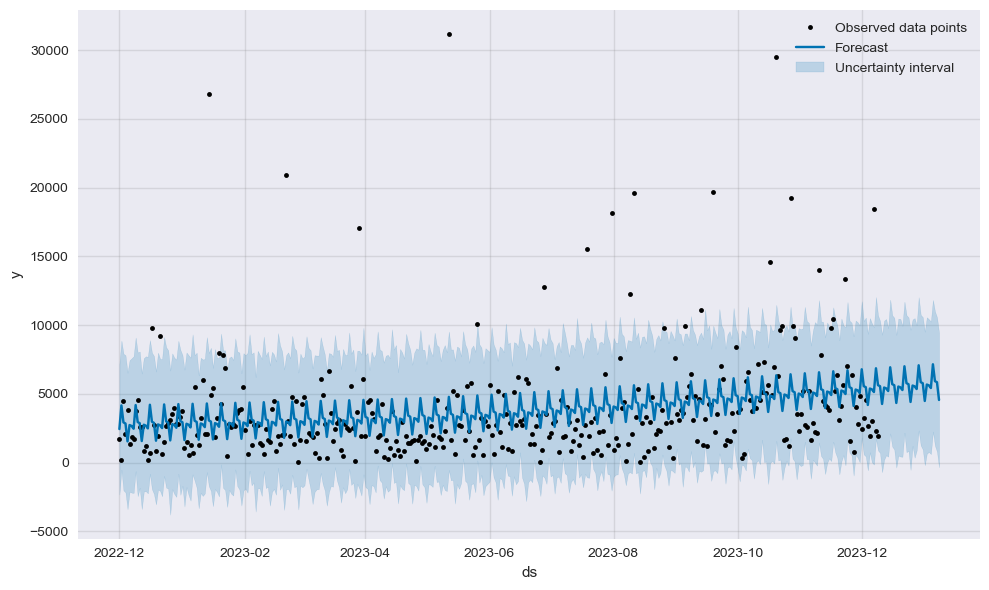

In [404]:
plot_forecast = plot(m, forecast_df, include_legend=True)

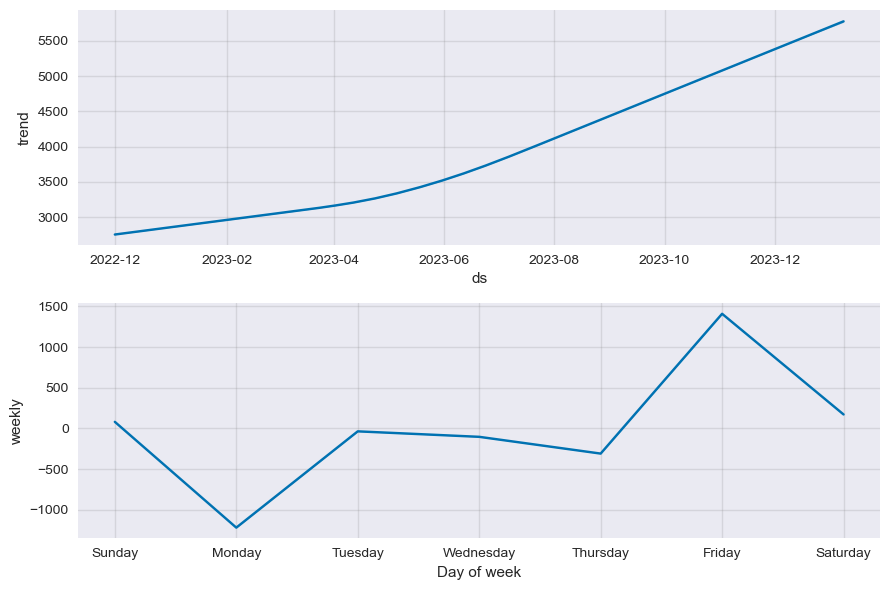

In [405]:
decompose_ = plot_components(m, forecast_df)

La tendencia aumenta constantemente sobre todo a partir del mes de junio. En cuanto a la estacionalidad el lunes es el día de menos y el viernes cuando alcanza el pico máximo.

### **Evaluación de las predicciones**

In [406]:
# Realizo partición train y test asiganndo un 80% de los días a train (hasta el 2023-10-01) y 20% a test.
train_df = df_rest.loc[df_rest['ds'] < '2023-10-01']
test_df = df_rest.loc[df_rest['ds'] >= '2023-10-01']

In [407]:
model_ml = Prophet(weekly_seasonality=True)
model_ml.fit(train_df)

17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing


In [408]:
future_ml_df = model_ml.make_future_dataframe(periods = len(test_df)+30, freq = 'D')
future_ml_df

ds
0   2022-12-01
1   2022-12-02
2   2022-12-03
3   2022-12-04
4   2022-12-05
..         ...
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

[404 rows x 1 columns]

In [409]:
forecast_ml_df = model_ml.predict(future_ml_df)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_ml_df

ds         yhat   yhat_lower   yhat_upper
0   2022-12-01  2044.421686 -2380.962621  6876.201222
1   2022-12-02  3553.003642  -995.151523  8268.725222
2   2022-12-03  3152.255545 -1683.146335  8048.365472
3   2022-12-04  2838.290930 -1837.801057  7420.696249
4   2022-12-05  1677.464541 -2874.807113  6029.376161
..         ...          ...          ...          ...
399 2024-01-04  3699.170526 -1121.259696  8326.201956
400 2024-01-05  5208.600177   525.901999  9558.966602
401 2024-01-06  4808.699776   345.711601  9369.776370
402 2024-01-07  4495.582856     7.526385  9114.023550
403 2024-01-08  3335.604163 -1065.908549  7693.932685

[404 rows x 4 columns]

In [410]:
px.line(pd.concat([df_rest.set_index('ds')['y'], forecast_ml_df.set_index('ds')['yhat']], axis = 1), title = 'Proyecciones con Prophet | Estacionalidad aditiva')

Se observa que la serie capta algo mejor el inicio de la serie cuando hay menos outliers pero a medida que aumenta la serie pierde eficacia. La tendencia sube muy ligeramente en toda la serie y el mes futuro en predicción seguiría la tendencia y tendría los valores más altos de la serie. 

In [411]:
m_pax_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True)
m_pax_mul.fit(train_df)

17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:16 - cmdstanpy - INFO - Chain [1] done processing


In [412]:
future_pax_mul = m_pax_mul.make_future_dataframe(periods =len(test_df)+30, freq = 'D')
display(future_pax_mul.head(10))
display(future_pax_mul.tail(10))

ds
0 2022-12-01
1 2022-12-02
2 2022-12-03
3 2022-12-04
4 2022-12-05
5 2022-12-06
6 2022-12-07
7 2022-12-08
8 2022-12-09
9 2022-12-10

ds
394 2023-12-30
395 2023-12-31
396 2024-01-01
397 2024-01-02
398 2024-01-03
399 2024-01-04
400 2024-01-05
401 2024-01-06
402 2024-01-07
403 2024-01-08

In [413]:
forecast_pax_mul = m_pax_mul.predict(future_pax_mul)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
px.line(pd.concat([df_rest.set_index('ds')['y'], forecast_pax_mul.set_index('ds')['yhat']], axis = 1), title = 'Proyecciones con Prophet - Estacionalidad multiplicativa')

Con el modelo multiplicativo observamos que al igual que la aditiva confome llegamos al final de la serie tiene dificultades para captar los valores debido a los ouliers. En cuanto a la tendencia y la evolución del mes de predicción pasa lo mismo que con el aditivo.

### **Evaluación cruzada**

Mediante la función de evaluación cruzada vamos a realizar la evaluación del modelo.

In [414]:
# Establecemos un periodo inicial de 120 días, aumentando el intervalo en 7 días y horizonte de 4 semanas al haber estacionalidad semanal.
cv_add = cross_validation(model = model_ml, initial='120 days', period='7 days', horizon = '28 days')

  0%|          | 0/23 [00:00<?, ?it/s]

17:09:17 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing
17:09:17 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing
17:09:17 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing
17:09:18 - cmdstanpy - INFO - Chain [1] start processing
17:09:18 - cmdstanpy - INFO - Chain [1] done processing
17:09:18 - cmdstanpy - INFO - Chain [1] start processing
17:09:18 - cmdstanpy - INFO - Chain [1] done processing
17:09:18 - cmdstanpy - INFO - Chain [1] start processing
17:09:18 - cmdstanpy - INFO - Chain [1] done processing
17:09:19 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing
17:09:19 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing
17:09:19 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1]

In [415]:
cv_mul = cross_validation(model = m_pax_mul,  initial='120 days', period='7 days', horizon = '28 days')

  0%|          | 0/23 [00:00<?, ?it/s]

17:09:24 - cmdstanpy - INFO - Chain [1] start processing
17:09:24 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
17:09:25 - cmdstanpy - INFO - Chain [1] start processing
17:09:26 - cmdstanpy - INFO - Chain [1] done processing
17:09:26 - cmdstanpy - INFO - Chain [1] start processing
17:09:26 - cmdstanpy - INFO - Chain [1] done processing
17:09:26 - cmdstanpy - INFO - Chain [1] start processing
17:09:26 - cmdstanpy - INFO - Chain [1] done processing
17:09:27 - cmdstanpy - INFO - Chain [1] start processing
17:09:27 - cmdstanpy - INFO - Chain [1] done processing
17:09:27 - cmdstanpy - INFO - Chain [1] start processing
17:09:27 - cmdstanpy - INFO - Chain [1]

In [416]:
df_performance_add = performance_metrics(cv_add)
display(df_performance_add)

horizon           mse         rmse          mae      mape     mdape  \
0   3 days  7.589060e+06  2754.824865  1709.383224  2.880717  0.441404   
1   4 days  1.267980e+07  3560.871043  2386.826944  3.535848  0.699344   
2   5 days  9.555394e+06  3091.179995  2159.143028  1.765494  0.639544   
3   6 days  2.549965e+07  5049.718027  2629.692061  1.423944  0.614988   
4   7 days  2.251739e+07  4745.249653  2467.534122  1.016651  0.615806   
5   8 days  1.784166e+07  4223.938640  2133.519800  0.936357  0.335855   
6   9 days  7.665657e+06  2768.692286  1718.970649  2.751592  0.563656   
7  10 days  7.693872e+06  2773.783013  1751.755926  2.693944  0.563656   
8  11 days  1.336737e+07  3656.141411  2492.412971  3.378024  0.759232   
9  12 days  1.041892e+07  3227.835317  2308.885701  1.787858  0.645962   
10 13 days  2.615865e+07  5114.552761  2767.621972  1.424321  0.566058   
11 14 days  2.270460e+07  4764.934455  2525.225114  1.053416  0.566058   
12 15 days  1.806469e+07  4250.258001  2197.501530  0.981315  0.436996   
13 16 days  7.818934e+06  2796.235629  1769.862570  2.418312  0.568583   
14 17 days  1.186835e+07  3445.047428  2028.310740  2.332889  0.554278   
15 18 days  1.727950e+07  4156.862249  2705.125340  2.950577  0.750414   
16 19 days  1.337613e+07  3657.339163  2441.046174  1.628852  0.596208   
17 20 days  2.617164e+07  5115.822654  2749.453587  1.294220  0.550084   
18 21 days  2.283157e+07  4778.239006  2527.212440  0.925812  0.545052   
19 22 days  1.824589e+07  4271.521329  2215.919533  0.861712  0.450003   
20 23 days  7.616565e+06  2759.812546  1736.381085  2.255535  0.531552   
21 24 days  1.151716e+07  3393.694270  1974.868431  2.161822  0.516036   
22 25 days  1.728231e+07  4157.199415  2689.678568  2.815035  0.778211   
23 26 days  1.372261e+07  3704.403584  2461.060215  1.544167  0.572408   
24 27 days  2.637351e+07  5135.514696  2753.787388  1.278631  0.506497   
25 28 days  2.285600e+07  4780.795276  2527.246103  0.864393  0.514983   

       smape  coverage  
0   0.623390  0.968750  
1   0.795964  0.909647  
2   0.678321  0.909647  
3   0.631125  0.888587  
4   0.608939  0.909647  
5   0.530919  0.932065  
6   0.630058  0.959918  
7   0.639042  0.968750  
8   0.813070  0.909647  
9   0.705083  0.909647  
10  0.660676  0.888587  
11  0.629428  0.909647  
12  0.553396  0.932065  
13  0.645527  0.959918  
14  0.663537  0.953125  
15  0.808923  0.878397  
16  0.681756  0.897418  
17  0.638134  0.891984  
18  0.611249  0.937500  
19  0.540947  0.947690  
20  0.614832  0.972147  
21  0.630486  0.953125  
22  0.795116  0.894022  
23  0.677345  0.881793  
24  0.632685  0.872962  
25  0.594477  0.881793

In [417]:
df_performance_mul = performance_metrics(cv_mul)
display(df_performance_mul.head(10))

horizon           mse         rmse          mae      mape     mdape  \
0  3 days  7.484054e+06  2735.699942  1704.058969  2.857644  0.465845   
1  4 days  1.256348e+07  3544.499872  2343.039988  3.429898  0.693793   
2  5 days  9.522015e+06  3085.776241  2096.533401  1.646147  0.612159   
3  6 days  2.561743e+07  5061.366320  2587.287724  1.340029  0.545037   
4  7 days  2.238480e+07  4731.257447  2399.571500  0.959249  0.571428   
5  8 days  1.766026e+07  4202.411143  2072.943700  0.882998  0.299111   
6  9 days  7.444294e+06  2728.423336  1662.655318  2.723611  0.446770   
7 10 days  7.608201e+06  2758.296707  1709.354433  2.669691  0.532007   
8 11 days  1.337062e+07  3656.585777  2431.516868  3.319195  0.775677   
9 12 days  1.047025e+07  3235.776607  2254.787856  1.715133  0.656348   

      smape  coverage  
0  0.625155  0.953125  
1  0.788513  0.913043  
2  0.660130  0.925272  
3  0.615006  0.900815  
4  0.589234  0.925272  
5  0.516030  0.947690  
6  0.618912  0.972147  
7  0.629737  0.968750  
8  0.798847  0.909647  
9  0.689178  0.909647

In [418]:
df_performance_add.describe().transpose()

count              mean                        std              min  \
horizon     26  15 days 12:00:00  7 days 15:33:52.928961624  3 days 00:00:00   
mse       26.0   16104496.167413             6595741.706031   7589060.036167   
rmse      26.0        3928.24872                 836.834805      2754.824865   
mae       26.0       2301.093278                 355.198148      1709.383224   
mape      26.0          1.883132                   0.838295         0.861712   
mdape     26.0          0.572418                   0.101978         0.335855   
smape     26.0           0.65517                   0.076201         0.530919   
coverage  26.0          0.919941                   0.032042         0.872962   

                      25%               50%               75%  \
horizon   9 days 06:00:00  15 days 12:00:00  21 days 18:00:00   
mse       10693480.823926   15501054.836859    22657798.83978   
rmse          3269.300055       3930.632917       4760.013255   
mae           2054.613005       2413.936559       2527.237687   
mape             1.109719          1.697173          2.625036   
mdape            0.519915          0.564857          0.615601   
smape            0.616971           0.63541          0.678077   
coverage         0.892493          0.909647          0.951766   

                       max  
horizon   28 days 00:00:00  
mse        26373511.189556  
rmse           5135.514696  
mae            2767.621972  
mape              3.535848  
mdape             0.778211  
smape              0.81307  
coverage          0.972147

In [419]:
df_performance_mul.describe().transpose()

count              mean                        std              min  \
horizon     26  15 days 12:00:00  7 days 15:33:52.928961624  3 days 00:00:00   
mse       26.0   16056752.922479              6631736.57268    7444293.89887   
rmse      26.0        3921.02264                 842.394061      2728.423336   
mae       26.0        2245.84753                 347.646609      1662.655318   
mape      26.0          1.839003                   0.855504         0.794759   
mdape     26.0          0.557537                   0.111288         0.299111   
smape     26.0          0.640613                    0.07566          0.51603   
coverage  26.0          0.921744                   0.031542         0.872962   

                      25%               50%               75%  \
horizon   9 days 06:00:00  15 days 12:00:00  21 days 18:00:00   
mse       10803696.234748   15299243.193469   22581627.119362   
rmse          3285.757444       3904.850984       4751.997867   
mae           2005.033197       2352.598242       2466.409216   
mape             1.049299          1.578224           2.61618   
mdape            0.499384          0.544985          0.583975   
smape            0.608559          0.622977          0.659982   
coverage          0.89572          0.913043          0.951766   

                       max  
horizon   28 days 00:00:00  
mse        26486642.386603  
rmse           5146.517501  
mae            2742.029418  
mape              3.429898  
mdape             0.805131  
smape             0.798847  
coverage          0.972147

El modelo multiplicativo es el que mejor funciona con Prophet ya que presenta unas métricas mejores que el aditivo. Durante el mes de predicción se observa que las ventas estarán en torno a los 5k.

### 4.2.2 Modelos de Boosting: XGBoost

In [420]:
df_rest = df_rest.set_index('ds')
df_rest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       374 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [421]:
y_train, y_test = temporal_train_test_split(df_rest, test_size=70)
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(304, 1)

y
ds                 
2022-12-01  1715.06
2022-12-02   167.90

y
ds                 
2023-09-29  2286.64
2023-09-30  8438.10

(70, 1)

y
ds                     
2023-10-01  3708.213000
2023-10-02  3869.887778

y
ds                 
2023-12-08  2335.88
2023-12-09  1933.57

In [422]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
               '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05',
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
 

In [423]:
y_train = y_train.asfreq("D")
# Sp (seasonal periodicity) = 7 porque tenemos estacionalidad semanal.
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_7 = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

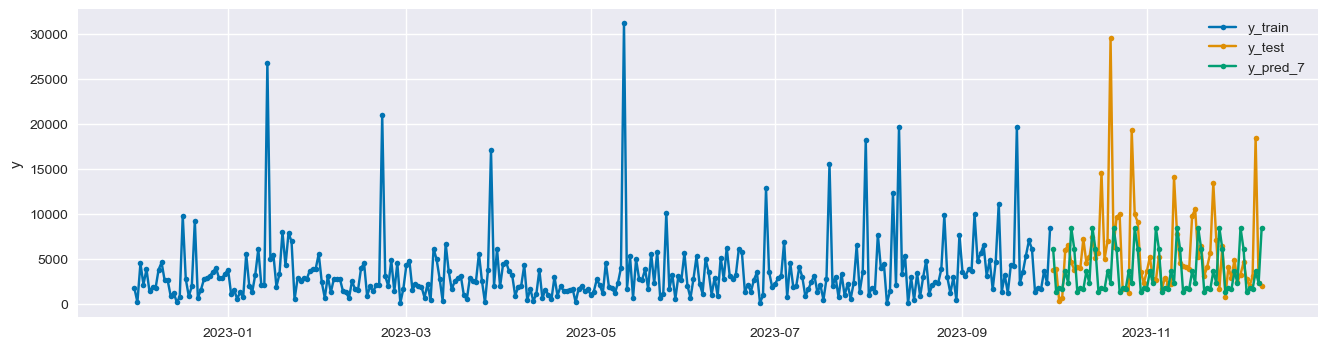

In [424]:
plot_series(y_train, y_test, y_pred_7, labels=["y_train", "y_test","y_pred_7"])

Este enfoque repite la estacionalidad semanal de la serie. Observamos que el modelo tiene dificultades para predecir la evolución de la serie temporal, sobre todo cuando se disparan las ventas pero aún así es el modelo que de momento mejor capta las ventas. A continuación, probamos con un modelo regresor recursivo ya que predice mejor las series temporales, su funcionamiento es sencillo predice el siguiente valor basándose en los anteriores.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

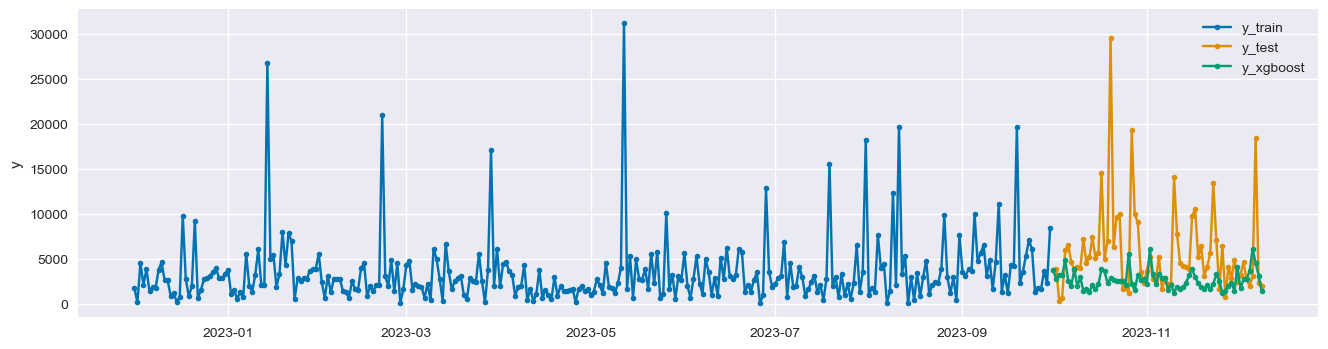

In [425]:
# objective='reg:squarederror': Indica que es un problema de regresión y que se usará el error cuadrático como función de pérdida.
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive")
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

In [426]:
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgboost)
mae_xgb = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgb = mean_squared_error(y_test, y_pred_xgboost, squared=False)

eval_xgb = [mape_xgb, mae_xgb, rmse_xgb]
pd.DataFrame(eval_xgb, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE     0.727924
MAE   3669.399949
RMSE  5747.537917

Tanto el MAE como el RMSE empeoran respecto a anteriores modelos analizados, sin embargo el MAPE mejora considerablemente. Una posible opción para mejorar la predicción es añadir transformadores y mejorar los hiperparámetros.

In [427]:
# Quitamos la estacionalidad.
desestacionalizador = Deseasonalizer(model="multiplicative", sp=7).fit(y_train)
y_train_desestacionalizado = desestacionalizador.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

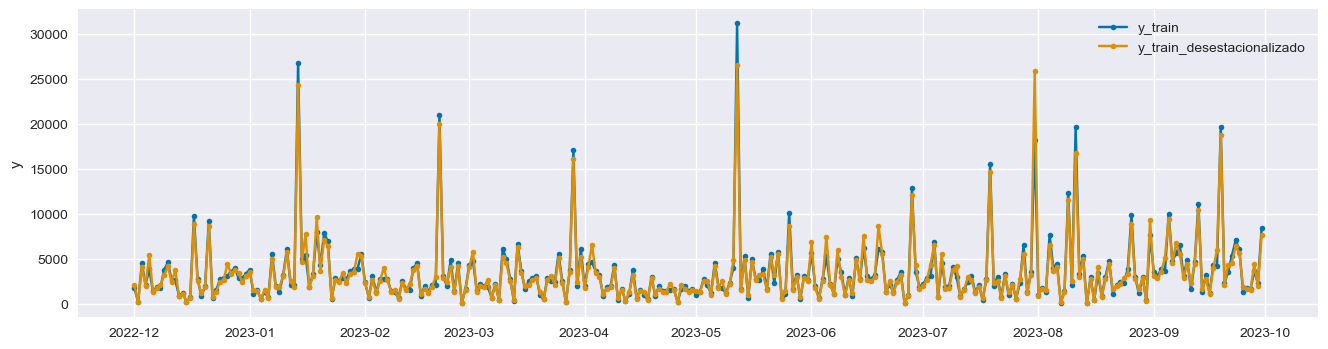

In [428]:
plot_series(y_train, y_train_desestacionalizado, labels=["y_train", "y_train_desestacionalizado"])

In [429]:
# Quitamos la tendencia.
detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1)).fit(y_train)
y_train_detrend = detrender.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

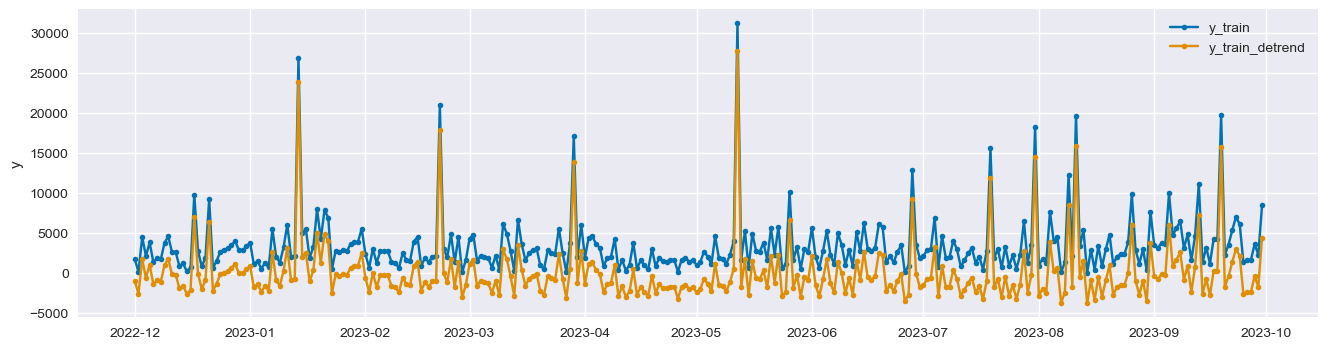

In [430]:
plot_series(y_train, y_train_detrend, labels=["y_train", "y_train_detrend"])

In [431]:
logtransform = LogTransformer().fit(y_train)
y_train_log = logtransform.transform(y_train)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

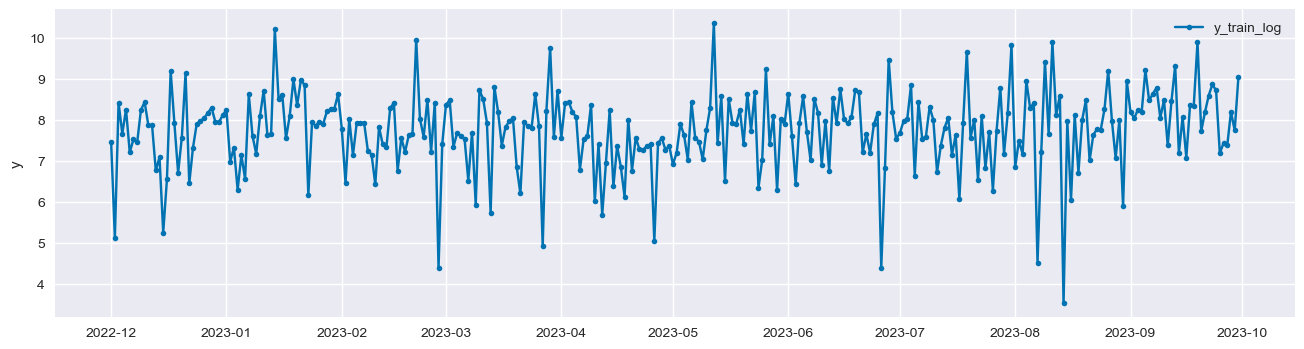

In [432]:
plot_series(y_train_log, labels=["y_train_log"])

Aplicando el logaritmo consigues que la serie sea aditiva en vez de multiplicativa. En multiplicativa las diferencias entre los primeros y últimos meses son marcadas y en esta serie vemos que el efecto de la estacionalidad es menor.

In [433]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)


forecaster  = TransformedTargetForecaster(
    [
        ("deseasonalize_year", Deseasonalizer(model="multiplicative", sp=7)),
        ('LogTransformer', LogTransformer()),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=12, scitype='tabular-regressor')),
    ]
)

forecaster.fit(y_train)
y_pred_transf = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

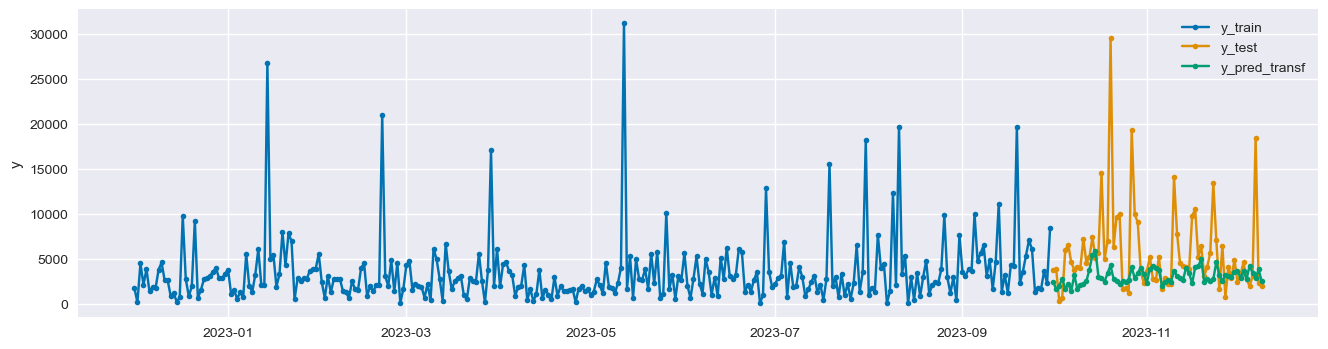

In [434]:
# Ajusta mejor que el anterior enfoque recursivo.
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

Utilizando TansformedTargetForecaster quitamos la estacionalidad, la tendencia, aplicamos logaritmo e indicamos que utilizamos el modelo XGBoost a la vez.

In [435]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=False)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE     0.607496
MAE   3243.493894
RMSE  5362.646410

Mejora la predicción con este nuevo enfoque respecto al recursivo, las tres métricas mejoran. Vamos a intentar seguir mejorando optimizando hiperparámetros, haciendo validación cruzada y re-entrenando.

### **Evaluación cruzada**

In [436]:
# Definimos el tamaño de la muestra para hacer la validación.
validation_size = len(y_test)
validation_size

70

In [437]:
# Definimos la muestra para la validación cruzada.
# Parte con 120 días y va añadiendo 7 días en las siguientes particiones (k-fold).
cv = ExpandingWindowSplitter(initial_window=120,
                                step_length=7,
                             fh=validation_size)

In [438]:
param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}

rscv = ForecastingRandomizedSearchCV(forecaster,
                                     cv=cv,
                                     param_distributions=param_grid,
                                     n_iter=100,
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)

In [439]:
# Trabajamos con el mejor modelo obtenido.
result_cv = rscv.fit(y_train)
y_pred_transf_cv = rscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

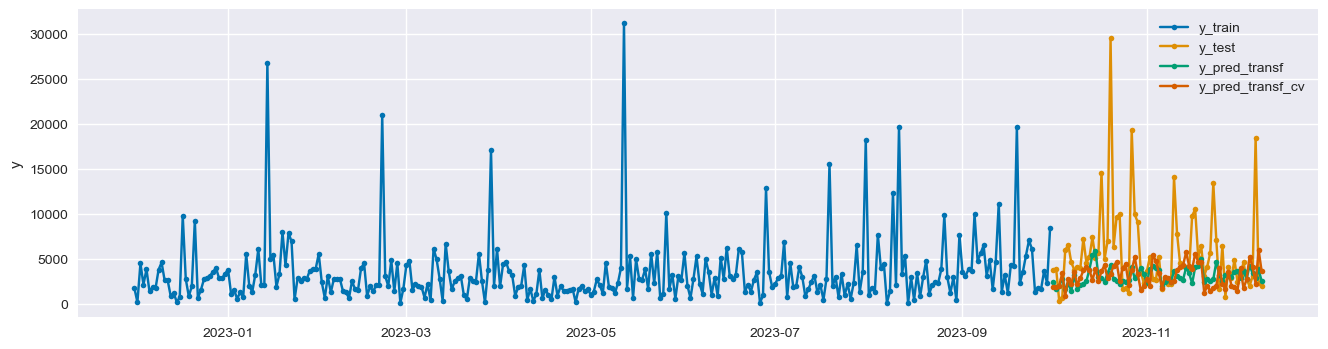

In [440]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

In [441]:
# Evaluacion

mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=False)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

eval_xgb_transf_cv
MAPE            0.669724
MAE          3405.420397
RMSE         5483.820099

La optimización de hiperparámetros no mejora las métricas en este caso.

In [442]:
# Genera una secuencia de fechas a partir del 9 de diciembre de 2023. Periods=30: Indica que se generarán 100 períodos diarios consecutivos desde el inicio de y_test (2023-10-01) hasta un mes depués del final de la serie (2024-01-08).
fhos = ForecastingHorizon(
    pd.date_range("2023-10-01", periods=100, freq="D"), 
    is_relative=False
)
fhos

ForecastingHorizon(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
               '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05',
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
 

In [443]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

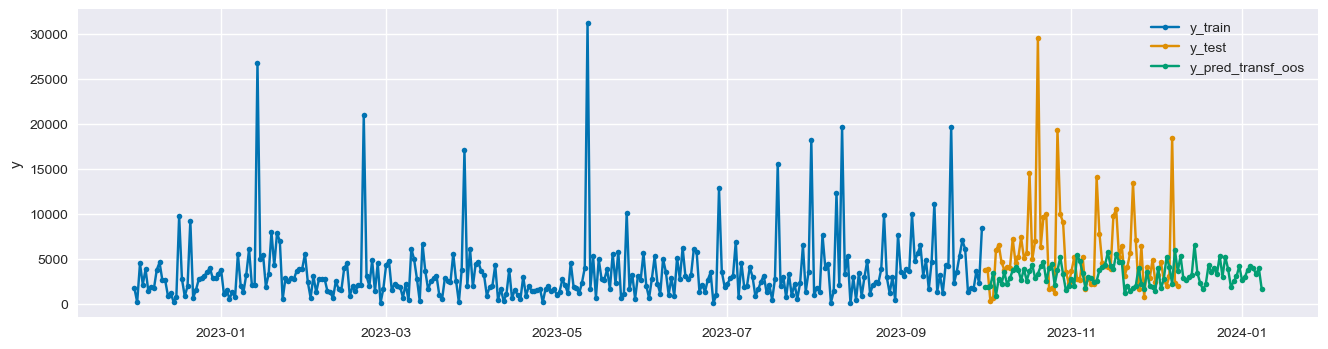

In [444]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])

En cuanto al mes futuro de predicción se parecia que las ventas se mantendrían estables sin outliers por arriba y por abajo. Las ventas se moverían entre los 4-5k.

### 4.2.3 Modelo ARIMA

Con el modelo ARIMA y su extensión SARIMA que tiene en cuenta la estacionalidad de la serie podemos realizar otro análisis para la predicción de los datos de la serie.

In [445]:
df_rest.index.freq = 'D'

In [446]:
px.line(df_rest['y'])

In [447]:
result_adf_pass = adfuller(df_rest['y'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_adf_pass))

{'adf': -18.045126890443132,
 'pvalue': 2.6501976559023987e-30,
 'usedlag': 0,
 'nobs': 373,
 'criticalvalues': {'1%': -3.448003816652923,
  '5%': -2.86931999731073,
  '10%': -2.5709145866785503},
 'icbest': 6932.472882121199}

El p-value nos indica que la serie es estacionaria. La d del modelo ARIMA sería d=0. También tenemos que corregir la estacionalidad.

In [448]:
# Estacionalidad cada 7 días.
df_rest['seas_diff'] = df_rest['y'] - df_rest['y'].shift(7)

In [449]:
px.line(df_rest['seas_diff'])

In [450]:
result_seas = adfuller((df_rest['seas_diff']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_seas))

{'adf': -7.634655567580699,
 'pvalue': 1.966984272080363e-11,
 'usedlag': 13,
 'nobs': 353,
 'criticalvalues': {'1%': -3.4490114443793214,
  '5%': -2.8697627072503757,
  '10%': -2.5711506161673716},
 'icbest': 6866.821595129269}

La serie sigue siendo estacionaria por lo que podemos decir que la D=0. Seguimos con el análisis de la autocorrelación y la autocorrelación parcial.

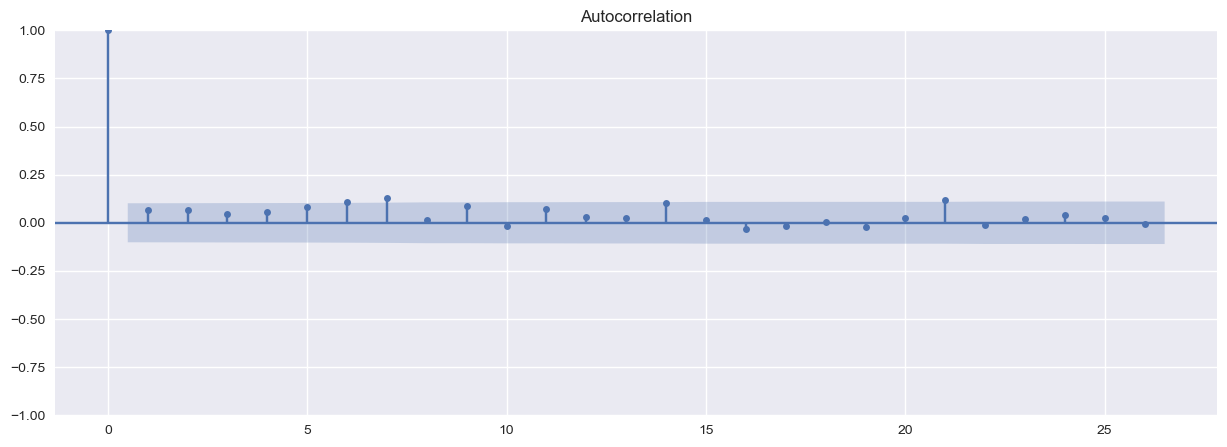

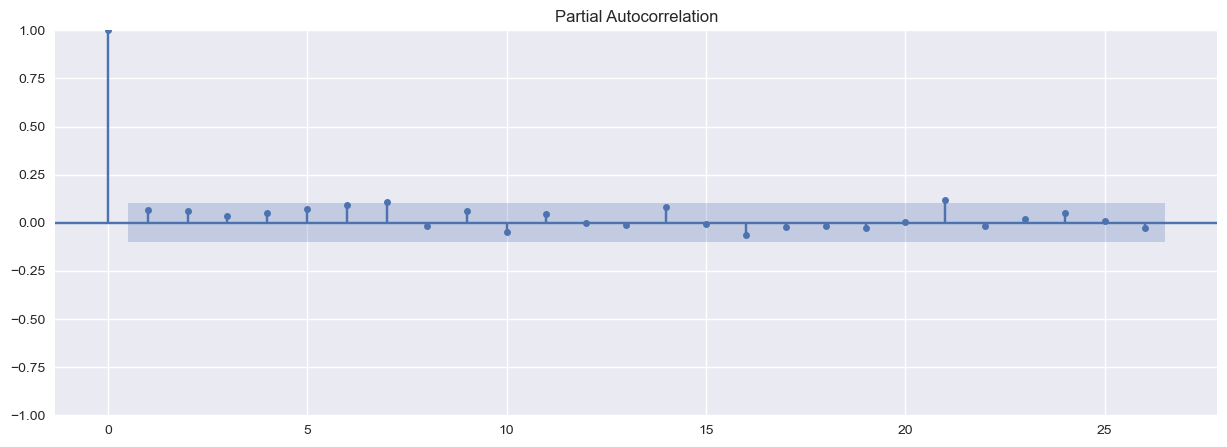

In [451]:
pax_acf = plot_acf(df_rest['y'].dropna())
pax_pacf = plot_pacf(df_rest['y'].dropna())

La p sería 7 y la q sería 7. También hay que analizar la ACF y la PACF según la perspectiva de la estacionalidad.

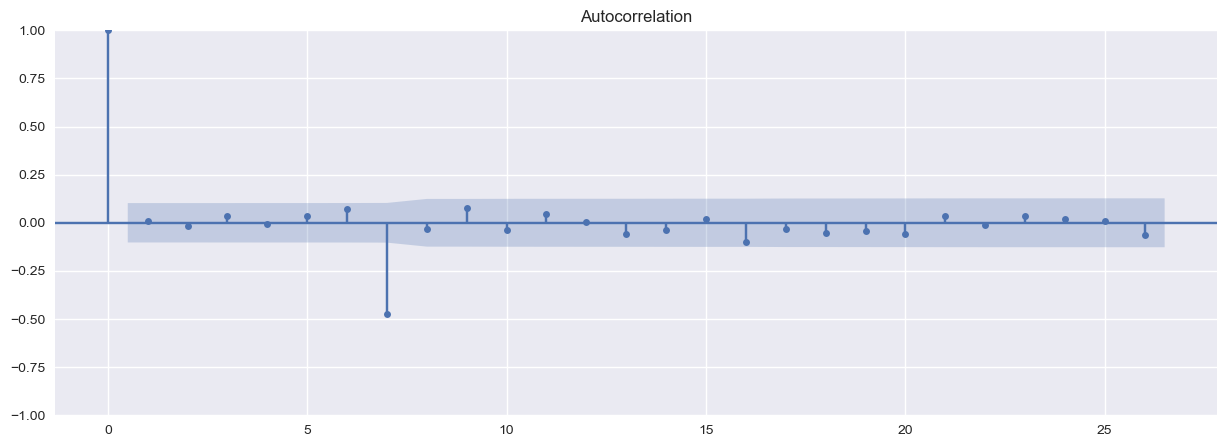

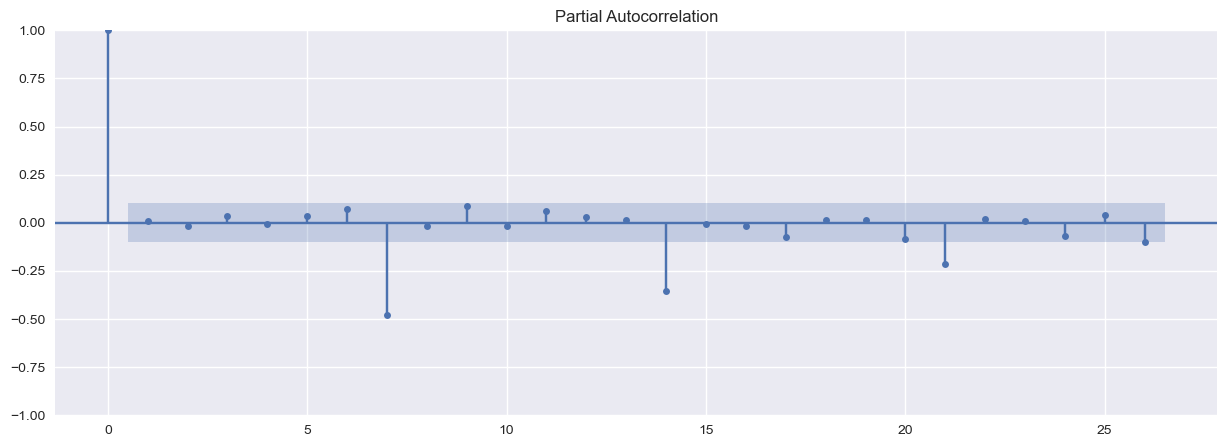

In [452]:
pax_seas_acf = plot_acf(df_rest['seas_diff'].dropna())
pax_seas_pacf = plot_pacf(df_rest['seas_diff'].dropna())

Como hay estacionalidad nos interesan los últimos dos gráficos ya que la tienen en cuenta, la P sería 7 y la Q sería 7.

### **Ajuste del modelo**

In [484]:
# Periodo estacional (s = 7): Representa un patrón que se repite cada 7 días.
# En order la P y la Q deberían ser 7 según los gráficos pero el SARIMAX no deja poner esos valores al ser igual a la estacionalidad (7) por eso resto un valor a cada uno.
# Con d=1 son las mejores métricas.
model_pax = SARIMAX(df_rest['y'],
                    order=(6,1,6), 
                    seasonal_order=(1, 0, 0, 7) 
                    )
result_pax = model_pax.fit()
result_pax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  374
Model:             SARIMAX(6, 1, 6)x(1, 0, [], 7)   Log Likelihood               -3616.131
Date:                            Sun, 05 Jan 2025   AIC                           7260.262
Time:                                    20:43:59   BIC                           7315.164
Sample:                                12-01-2022   HQIC                          7282.063
                                     - 12-09-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3645      0.824     -0.442      0.658      -1.979       1.250
ar.L2         -0.4172      0.769     -0.543      0.587      -1.924       1.089
ar.L3         -0.1640      0.753     -0.218      0.828      -1.641       1.313
ar.L4         -0.1906      0.810     -0.235      0.814      -1.777       1.396
ar.L5         -0.5425      0.598     -0.907      0.365      -1.715       0.630
ar.L6          0.0517      0.141      0.366      0.714      -0.225       0.328
ma.L1         -0.5902      0.817     -0.723      0.470      -2.191       1.011
ma.L2          0.0522      1.140      0.046      0.963      -2.182       2.286
ma.L3         -0.2622      0.885     -0.296      0.767      -1.998       1.473
ma.L4          0.0241      0.983      0.024      0.980      -1.903       1.951
ma.L5          0.4542      0.989      0.459      0.646      -1.484       2.392
ma.L6         -0.6239      0.579     -1.078      0.281      -1.758       0.510
ar.S.L7        0.1488      0.092      1.618      0.106      -0.031       0.329
sigma2      1.663e+07   7.74e-07   2.15e+13      0.000    1.66e+07    1.66e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              5003.59
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             3.43
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.72e+29. Standard errors may be unstable.
"""

### **Diagnosis del modelo**

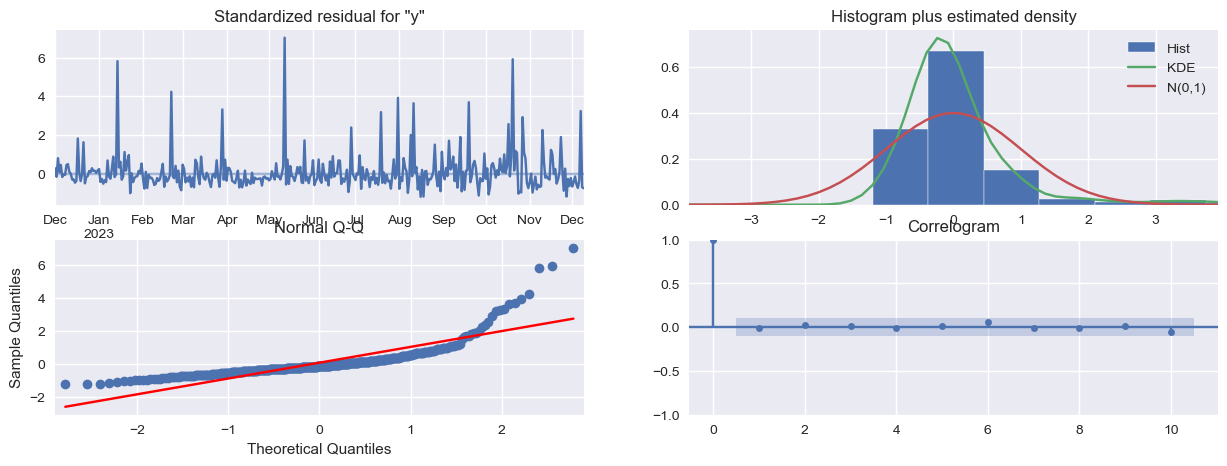

In [454]:
result_pax.plot_diagnostics()
plt.show()

Se observa que los 4 gráficos reflejan que se captan de manera aceptable los valores de la serie salvo los outliers de los últimos meses de la serie. A continuación, comenzamos con las predicciones.

### **Predicciones**

In [455]:
# Paso 1: Creamos data frame para almacenar predicciones.

new_dates_test = pd.date_range('2023-12-10', freq = 'D', periods=30) # Predecimos un mes desde el fin de la serie.


df_pred = pd.DataFrame(pd.to_datetime(new_dates_test))
df_pred.columns = ['Month']
df_pred.set_index('Month', inplace = True)
df_pred['y'] = np.nan
df_pred.rename_axis(None, inplace=True)
df_pred = df_pred.sort_index(ascending=True)
df_pred.index.freq = 'D'
df_pred

y
2023-12-10 NaN
2023-12-11 NaN
2023-12-12 NaN
2023-12-13 NaN
2023-12-14 NaN
2023-12-15 NaN
2023-12-16 NaN
2023-12-17 NaN
2023-12-18 NaN
2023-12-19 NaN
2023-12-20 NaN
2023-12-21 NaN
2023-12-22 NaN
2023-12-23 NaN
2023-12-24 NaN
2023-12-25 NaN
2023-12-26 NaN
2023-12-27 NaN
2023-12-28 NaN
2023-12-29 NaN
2023-12-30 NaN
2023-12-31 NaN
2024-01-01 NaN
2024-01-02 NaN
2024-01-03 NaN
2024-01-04 NaN
2024-01-05 NaN
2024-01-06 NaN
2024-01-07 NaN
2024-01-08 NaN

In [456]:
# Paso 2: Creamos dataframe con los valores observados y las fechas futuras.

df_now_after = pd.concat([df_rest,df_pred])
display(df_now_after.head(5))
display(df_now_after.tail(5))

y  seas_diff
2022-12-01  1715.06        NaN
2022-12-02   167.90        NaN
2022-12-03  4471.82        NaN
2022-12-04  2118.26        NaN
2022-12-05  3811.07        NaN

y  seas_diff
2024-01-04 NaN        NaN
2024-01-05 NaN        NaN
2024-01-06 NaN        NaN
2024-01-07 NaN        NaN
2024-01-08 NaN        NaN

<Axes: >

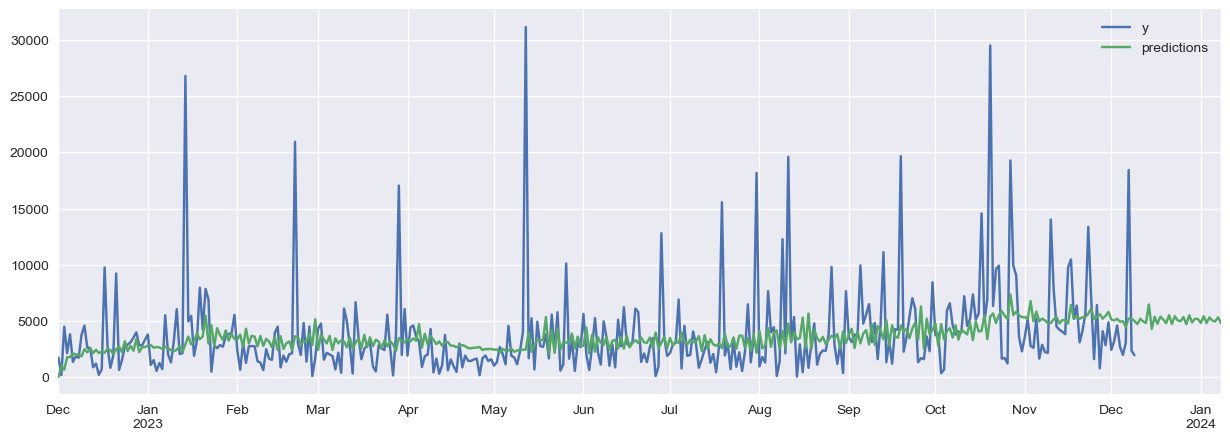

In [457]:
# Paso 3: Creamos las predicciones con el método predict.

df_now_after['predictions'] = result_pax.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y','predictions']].plot()

Aplicando logaritmos seguramente mejoremos el modelo y y podremos calcular las métricas definitivas del modelo.

In [ ]:
df_rest['y_log'] = df_rest['y'].apply(np.log)

In [ ]:
# pax_log_acf = plot_acf(df_rest['y_log'].dropna())
# pax_lof_pacf = plot_pacf(df_rest['y_log'].dropna())

In [486]:
# La p y la q son iguales a 6. Con d=1 da el mejor resultado.
# Estima el modelo
model_pax_transf = SARIMAX(df_uk['y_log'],
                    order=(6,1,6), # orden de la serie
                    seasonal_order=(1, 0, 0, 7) # orden estacional
                    )
result_pax_transf = model_pax_transf.fit()
result_pax_transf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              y_log   No. Observations:                  374
Model:             SARIMAX(6, 1, 6)x(1, 0, [], 7)   Log Likelihood                -181.946
Date:                            Sun, 05 Jan 2025   AIC                            391.891
Time:                                    20:44:40   BIC                            446.793
Sample:                                12-01-2022   HQIC                           413.692
                                     - 12-09-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3279      0.191     -6.951      0.000      -1.702      -0.953
ar.L2         -1.1385      0.380     -2.997      0.003      -1.883      -0.394
ar.L3         -0.5781      0.441     -1.312      0.190      -1.442       0.286
ar.L4         -0.0493      0.342     -0.144      0.885      -0.720       0.621
ar.L5          0.0408      0.174      0.234      0.815      -0.300       0.382
ar.L6         -0.3737      0.084     -4.445      0.000      -0.539      -0.209
ma.L1          0.6015      0.199      3.021      0.003       0.211       0.992
ma.L2          0.0186      0.233      0.080      0.936      -0.439       0.476
ma.L3         -0.5171      0.140     -3.702      0.000      -0.791      -0.243
ma.L4         -0.6374      0.082     -7.786      0.000      -0.798      -0.477
ma.L5         -0.2237      0.186     -1.204      0.229      -0.588       0.140
ma.L6          0.5207      0.165      3.162      0.002       0.198       0.843
ar.S.L7        0.0649      0.081      0.798      0.425      -0.095       0.224
sigma2         0.1517      0.010     15.039      0.000       0.132       0.172
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                19.52
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.06
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

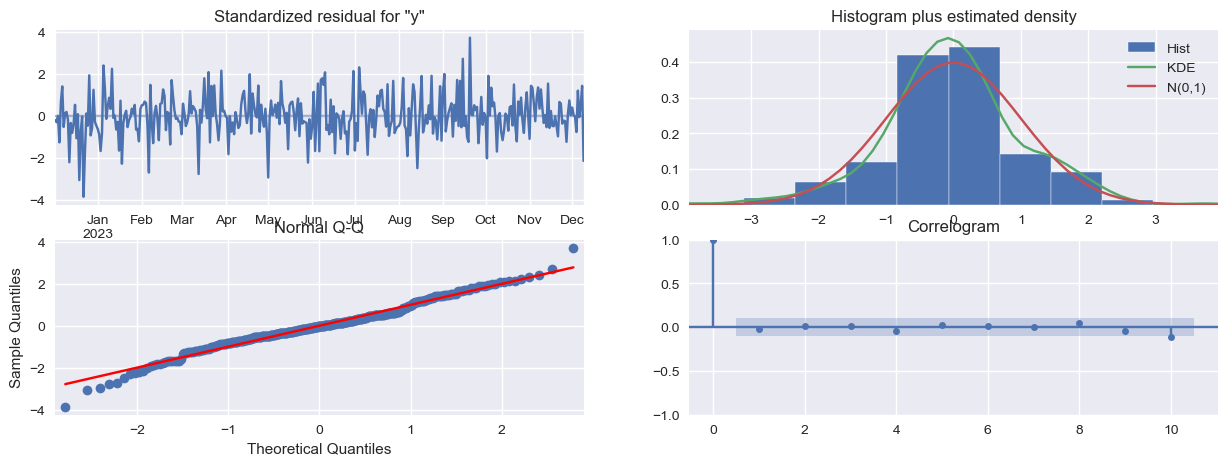

In [459]:
result_pax_transf.plot_diagnostics()
plt.show()

Los 4 gráficos muestran una mejora en la captura de los valores de ventas.

In [460]:
df_now_after['y_log'] = df_now_after['y'].apply(np.log)
df_now_after

y  seas_diff  predictions     y_log
2022-12-01  1715.06        NaN     0.000000  7.447203
2022-12-02   167.90        NaN   979.230679  5.123369
2022-12-03  4471.82        NaN   656.150313  8.405551
2022-12-04  2118.26        NaN  1754.755481  7.658350
2022-12-05  3811.07        NaN  1766.543417  8.245665
...             ...        ...          ...       ...
2024-01-04      NaN        NaN  5303.450162       NaN
2024-01-05      NaN        NaN  5030.648213       NaN
2024-01-06      NaN        NaN  4940.950998       NaN
2024-01-07      NaN        NaN  5320.296885       NaN
2024-01-08      NaN        NaN  4793.268665       NaN

[404 rows x 4 columns]

<Axes: >

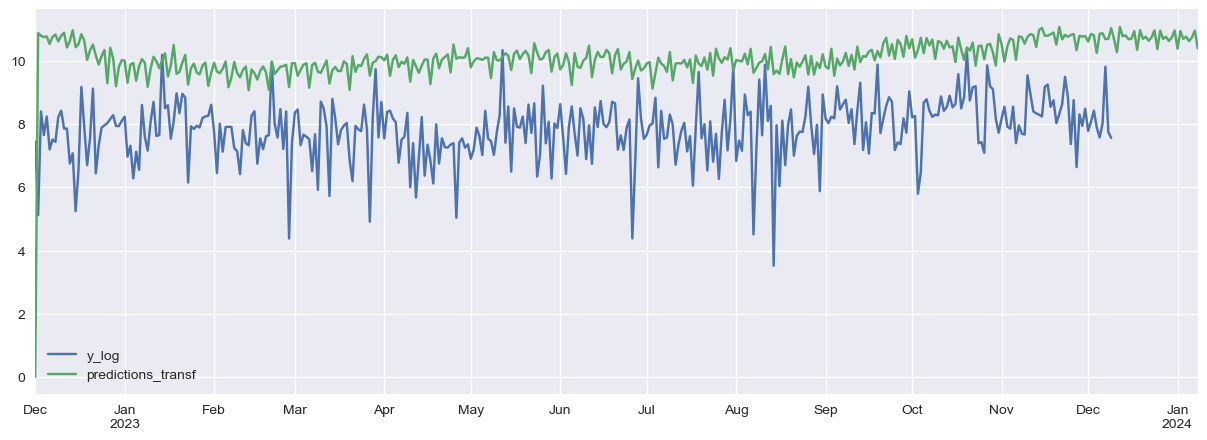

In [461]:
df_now_after['predictions_transf'] = result_pax_transf.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y_log','predictions_transf']].plot()

In [462]:
# Es necesario aplicar la función exponencial a la logarítmica para poder comparar los valores con la serie original.
df_now_after['pred_transf_rev'] = df_now_after['predictions_transf'].apply(np.exp)
df_now_after

y  seas_diff  predictions     y_log  predictions_transf  \
2022-12-01  1715.06        NaN     0.000000  7.447203            0.000000   
2022-12-02   167.90        NaN   979.230679  5.123369           10.887820   
2022-12-03  4471.82        NaN   656.150313  8.405551           10.801512   
2022-12-04  2118.26        NaN  1754.755481  7.658350           10.758997   
2022-12-05  3811.07        NaN  1766.543417  8.245665           10.781799   
...             ...        ...          ...       ...                 ...   
2024-01-04      NaN        NaN  5303.450162       NaN           10.773543   
2024-01-05      NaN        NaN  5030.648213       NaN           10.634048   
2024-01-06      NaN        NaN  4940.950998       NaN           10.748354   
2024-01-07      NaN        NaN  5320.296885       NaN           10.965874   
2024-01-08      NaN        NaN  4793.268665       NaN           10.406548   

            pred_transf_rev  
2022-12-01         1.000000  
2022-12-02     53520.475857  
2022-12-03     49094.971669  
2022-12-04     47051.447941  
2022-12-05     48136.624426  
...                     ...  
2024-01-04     47740.870315  
2024-01-05     41524.863437  
2024-01-06     46553.323173  
2024-01-07     57865.321575  
2024-01-08     33075.499959  

[404 rows x 6 columns]

<Axes: >

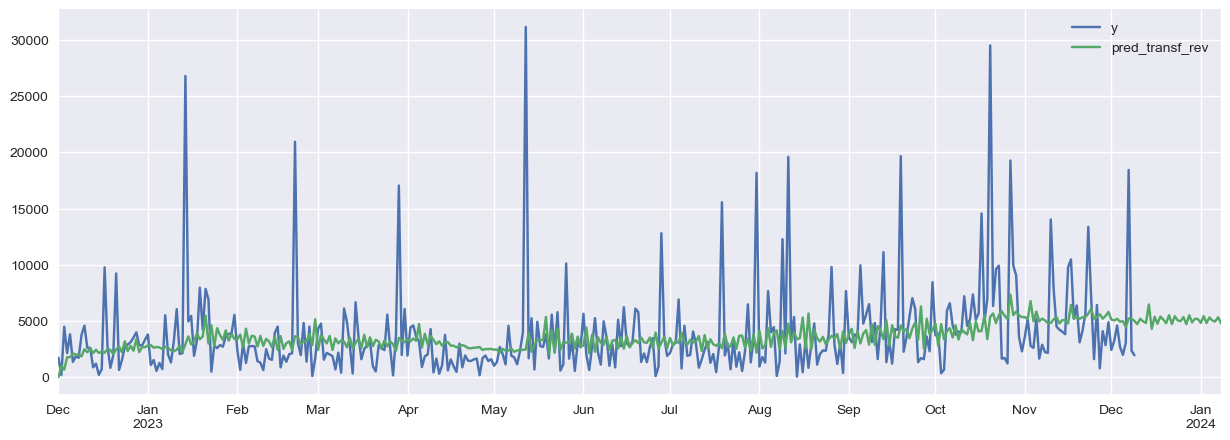

In [463]:
df_now_after['pred_transf_rev'] = result_pax.predict(start=0,end=len(df_now_after)) # meses totales para hacer la predicción in y out sample
df_now_after[['y','pred_transf_rev']].plot()

El modelo tiene dificultades para capturar los valores de la serie sobre todo a partir del mes de agosto, para el mes en predicción las ventas se mantendrían estables en torno a los 5k. El modelo logarítmico capta mejor los valores de ventas de UK que del resto de países.

In [464]:
df_now_after_eval = df_now_after.dropna()
df_now_after_eval

y     seas_diff  predictions     y_log  \
2022-12-08   1708.650000     -6.410000  1980.395102  7.443459   
2022-12-09   3759.580000   3591.680000  1839.926520  8.232063   
2022-12-10   4573.510000    101.690000  2478.992942  8.428036   
2022-12-11   2598.917778    480.657778  2197.120757  7.862850   
2022-12-12   2598.917778  -1212.152222  2562.134611  7.862850   
...                  ...           ...          ...       ...   
2023-12-05   1963.050000  -2119.040000  4968.698784  7.582255   
2023-12-06   3035.140000    204.380000  4462.009684  8.018013   
2023-12-07  18442.790000  13560.550000  5216.561310  9.822429   
2023-12-08   2335.880000    -80.120000  5174.766176  7.756144   
2023-12-09   1933.570000  -1292.610000  4993.721318  7.567123   

            predictions_transf  pred_transf_rev  
2022-12-08           10.840295      1980.395102  
2022-12-09           10.621792      1839.926520  
2022-12-10           10.805651      2478.992942  
2022-12-11           10.896240      2197.120757  
2022-12-12           10.431061      2562.134611  
...                        ...              ...  
2023-12-05           10.864567      4968.698784  
2023-12-06           10.881063      4462.009684  
2023-12-07           10.697396      5216.561310  
2023-12-08           10.699300      5174.766176  
2023-12-09           11.042313      4993.721318  

[367 rows x 6 columns]

In [465]:
# Utilizo el intervalo [297:403] para ajustar los valores con el y_test.
mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, df_now_after_eval['pred_transf_rev'][297:403])
mae_xgb_transf_cv = mean_absolute_error(y_test, df_now_after_eval['pred_transf_rev'][297:403])
rmse_xgb_transf_cv = mean_squared_error(y_test, df_now_after_eval['pred_transf_rev'][297:403], squared=False)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

eval_xgb_transf_cv
MAPE            0.952741
MAE          3060.037476
RMSE         4749.814261

Aplicando logaritmos obtenemos el mejor modelo SARIMAX de todos los estudiados anteriormente. Eso se debe a que estabiliza la varianza y reduce el efecto de los outliers positivos que en esta serie distorsionaban los modelos analizados.

Analizados ya todos los modelos de las ventas del resto de países el modelo con mejores métricas es el multiplicativo de Prophet el que presenta los menores MAE (2245.84) y RMSE (3921.02). El modelo que presenta mejor MAPE (0.60) es el modelo XGBOOST aplicando transformadores.

Como hipótesis las diferencias entre la predicción y los resultados a partir de agosto se puede deber a promociones en esas fechas o que sus ventas sean mayores de normal en esas fechas dado que puedan vender productos para Navidad o que tengan relación con el invierno.
